In [1]:
import pandas as pd
import numpy as np

def rstr(df, pred=None): 
    """
    Generates a statistical summary table. FIX: Ensures all metrics are 
    explicitly reindexed to df.columns to guarantee alignment and prevent 
    the persistent ValueError: Length mismatch.
    """
    
    # --- 1. CORE METRICS CALCULATION (ALIGNMENT CRITICAL) ---
    obs = df.shape[0]
    
    # Calculate all metrics as Series
    types = df.dtypes
    counts = df.count()
    distincts = df.nunique()
    nulls = df.isnull().sum()
    missing_ration = (nulls / obs) * 100
    
    # Calculate statistics and REINDEX EVERYTHING to df.columns
    # This guarantees all Series have the length df.shape[1] (which is 8).
    full_index = df.columns
    
    # For alignment safety, reindex all Series, even if they were full length
    types = types.reindex(full_index)
    counts = counts.reindex(full_index)
    distincts = distincts.reindex(full_index)
    nulls = nulls.reindex(full_index)
    missing_ration = missing_ration.reindex(full_index)
    
    # Skewness/Kurtosis (Numeric only, then reindexed to full length)
    skewness = df.skew(numeric_only=True).reindex(full_index) 
    kurtosis = df.kurt(numeric_only=True).reindex(full_index)
    
    # Unique values logic (already full index, but reindex for safety)
    uniques = df.apply(lambda x: list(x.dropna().unique()[:5])).astype(str).reindex(full_index)
    
    print('Data shape:', df.shape)
    
    # Define the base components for concatenation
    base_series = [types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis]
    base_cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ratio', 'uniques', 'skewness', 'kurtosis']
    
    # --- 2. CONDITIONAL CONCATENATION ---
    
    if pred is None:
        str_ = pd.concat(base_series, axis=1)
        str_.columns = base_cols
    else:
        # Align corr as well
        corr = df.corr(numeric_only=True)[pred].reindex(full_index)
        
        extended_series = base_series + [corr]
        corr_col = f'corr_{pred}'
        extended_cols = base_cols + [corr_col]

        str_ = pd.concat(extended_series, axis=1)
        str_.columns = extended_cols
        
    print('___________________________\nData types:\n', str_['types'].value_counts())
    print('___________________________')
    
    return str_

In [2]:
cs_df = pd.read_excel(r"C:\Users\ESURU MAHARAJU\Downloads\Online Retail.xlsx")

In [3]:
import pandas as pd
import numpy as np # Used for robustness checks

def rstr(df, pred=None):
    """
    Generates a statistical summary table for a pandas DataFrame, 
    including data types, nulls, distinct counts, and distribution statistics.
    If 'pred' is provided, it includes correlation with the predictor.
    """
    
    # --- 1. CORE METRICS CALCULATION ---
    obs = df.shape[0]
    types = df.dtypes
    counts = df.count()
    distincts = df.nunique()
    nulls = df.isnull().sum()
    missing_ration = (nulls / obs) * 100
    
    # Safely compute statistics only for numeric columns
    numeric_df = df.select_dtypes(include=np.number)
    skewness = numeric_df.skew()
    kurtosis = numeric_df.kurt()
    
    # Store unique values (first 10 for display)
    uniques = df.apply(lambda x: x.unique()[:10]) 

    print('Data shape:', df.shape)
    
    # Define the core series to concatenate
    base_series = [types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis]
    base_cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ratio', 'uniques', 'skewness', 'kurtosis']
    
    # --- 2. CONCATENATION LOGIC (FIXED SYNTAX) ---
    
    if pred is None:
        # Concatenate base series
        str_ = pd.concat(
            base_series, # Corrected: list of series is passed
            axis=1
        )
        str_.columns = base_cols
    else:
        # Calculate correlation with the predictor 'pred'
        corr = df.corr(numeric_only=True)[pred]
        
        # Build the final lists for concatenation
        extended_series = base_series + [corr] # Added 'corr' to the list
        extended_cols = base_cols + [f'corr_{pred}']
        
        # Concatenate all series
        str_ = pd.concat(
            extended_series, # Corrected: list of series is passed
            axis=1
        )
        str_.columns = extended_cols # Corrected to use the full list of columns
    
    # --- 3. FINAL OUTPUT ---
    print('___________________________\nData types:\n', str_['types'].value_counts())
    print('___________________________')
    
    return str_

In [4]:
cs_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [5]:
# Assuming cs_df is the DataFrame loaded in the previous step
import numpy as np # Ensure numpy is available for checks if needed

# --- 1. Check for Simultaneous Negative Values (Highly Suspicious) ---
print('Check if we had negative quantity and prices at the same register:',
      'No' if cs_df[(cs_df.Quantity < 0) & (cs_df.UnitPrice < 0)].shape[0] == 0 else 'Yes')

# --- 2. Check for Negative Quantity or Zero/Negative Price (Returns/Faulty) ---
# This condition typically catches cancellations/returns (Quantity < 0, Price > 0) or cleanup records.
negative_or_zero_price_and_quantity = cs_df[(cs_df.Quantity <= 0) | (cs_df.UnitPrice <= 0)]
print('\nCheck how many registers have Quantity <= 0 OR UnitPrice <= 0:',
      negative_or_zero_price_and_quantity.shape[0])

# --- 3. Identify Customers Involved in These Records ---
print('\nWhat are the Customer IDs of the registers above:',
      negative_or_zero_price_and_quantity['CustomerID'].dropna().unique())

# --- 4. Calculate Percentage of Negative Quantity Records ---
negative_quantity_count = cs_df[(cs_df.Quantity < 0)].shape[0]
total_records = cs_df.shape[0]
print('\n% Negative Quantity (likely returns/cancellations): {:3.2%}'.format(
      negative_quantity_count / total_records))

# --- 5. Inspect Invoice Prefixes for Negative Quantity Records (e.g., 'C' for Cancel) ---
# Note: This checks only records with a valid CustomerID
negative_invoices_prefix = (
    cs_df.loc[(cs_df.Quantity < 0) & cs_df.CustomerID.notnull(), 'InvoiceNo']
    .apply(lambda x: x[0]) # Get the first character
    .unique()
)
print('\nAll registers with negative quantity and valid CustomerID have Invoice start with:', 
      negative_invoices_prefix)

# --- 6. Display Example for Manual Inspection ---
# Customer ID 12472 is used as a specific example (replace if necessary)
print('\nSee an example of negative quantity and others related records (e.g., Customer 12472):')
# Using a common StockCode to ensure the example displays meaningful rows
example_stock_code = 22244 
display(cs_df[(cs_df.CustomerID == 12472) & (cs_df.StockCode == example_stock_code)])

Check if we had negative quantity and prices at the same register: No

Check how many registers have Quantity <= 0 OR UnitPrice <= 0: 11805

What are the Customer IDs of the registers above: [14527. 15311. 17548. ... 12985. 15951. 16446.]

% Negative Quantity (likely returns/cancellations): 1.96%

All registers with negative quantity and valid CustomerID have Invoice start with: ['C']

See an example of negative quantity and others related records (e.g., Customer 12472):


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1973,C536548,22244,3 HOOK HANGER MAGIC GARDEN,-4,2010-12-01 14:33:00,1.95,12472.0,Germany
9438,537201,22244,3 HOOK HANGER MAGIC GARDEN,12,2010-12-05 14:19:00,1.95,12472.0,Germany
121980,546843,22244,3 HOOK HANGER MAGIC GARDEN,12,2011-03-17 12:40:00,1.95,12472.0,Germany


In [6]:
# --- 1. Check Register with UnitPrice Negative ---
print('Check registers with UnitPrice negative:')
# Negative prices are highly suspicious/data errors and should be inspected.
display(cs_df[(cs_df.UnitPrice < 0)])

# --- 2. Check Sales Records with Zero Unit Price and Valid Customer ID ---
# Zero UnitPrice with a valid Customer ID often indicates promotional items or free samples.
zero_price_valid_customer = cs_df[(cs_df.UnitPrice == 0) & cs_df.CustomerID.notnull()]

print("\nSales records with Customer ID and zero in Unit Price:", zero_price_valid_customer.shape[0])

# Display the resulting records for verification
display(zero_price_valid_customer)

Check registers with UnitPrice negative:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom



Sales records with Customer ID and zero in Unit Price: 40


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom


In [7]:
import pandas as pd
import numpy as np

def rstr(df, pred=None): 
    """
    Generates a statistical summary table. FIX: Ensures all metrics are 
    explicitly reindexed to df.columns to guarantee alignment and prevent 
    the persistent ValueError: Length mismatch.
    """
    
    # --- 1. CORE METRICS CALCULATION (ALIGNMENT CRITICAL) ---
    obs = df.shape[0]
    
    # Calculate all metrics as Series
    types = df.dtypes
    counts = df.count()
    distincts = df.nunique()
    nulls = df.isnull().sum()
    missing_ration = (nulls / obs) * 100
    
    # Calculate statistics and REINDEX EVERYTHING to df.columns
    # This guarantees all Series have the length df.shape[1] (which is 8).
    full_index = df.columns
    
    # For alignment safety, reindex all Series, even if they were full length
    types = types.reindex(full_index)
    counts = counts.reindex(full_index)
    distincts = distincts.reindex(full_index)
    nulls = nulls.reindex(full_index)
    missing_ration = missing_ration.reindex(full_index)
    
    # Skewness/Kurtosis (Numeric only, then reindexed to full length)
    skewness = df.skew(numeric_only=True).reindex(full_index) 
    kurtosis = df.kurt(numeric_only=True).reindex(full_index)
    
    # Unique values logic (already full index, but reindex for safety)
    uniques = df.apply(lambda x: list(x.dropna().unique()[:5])).astype(str).reindex(full_index)
    
    print('Data shape:', df.shape)
    
    # Define the base components for concatenation
    base_series = [types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis]
    base_cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ratio', 'uniques', 'skewness', 'kurtosis']
    
    # --- 2. CONDITIONAL CONCATENATION ---
    
    if pred is None:
        str_ = pd.concat(base_series, axis=1)
        str_.columns = base_cols
    else:
        # Align corr as well
        corr = df.corr(numeric_only=True)[pred].reindex(full_index)
        
        extended_series = base_series + [corr]
        corr_col = f'corr_{pred}'
        extended_cols = base_cols + [corr_col]

        str_ = pd.concat(extended_series, axis=1)
        str_.columns = extended_cols
        
    print('___________________________\nData types:\n', str_['types'].value_counts())
    print('___________________________')
    
    return str_

In [9]:
# Assuming 'cs_df' is the cleaned DataFrame

# --- 1. Identify StockCodes with Multiple Descriptions (Data Quality Check) ---

# Group by StockCode and Description, then count InvoiceNo (or any column)
# This gives a unique list of (StockCode, Description) pairs.
cat_des_df = cs_df.groupby(["StockCode", "Description"]).size().reset_index(name='Count')

# Count how many unique descriptions each StockCode has
description_counts = cat_des_df.StockCode.value_counts()

# Filter for StockCodes that appear more than once (i.e., have >1 description)
ambiguous_stockcodes = description_counts[description_counts > 1].index

print(f"Number of StockCodes with Ambiguous Descriptions: {len(ambiguous_stockcodes)}")

# --- 2. Inspect an Example of the Ambiguity ---

# Select the most frequently occurring ambiguous StockCode for inspection
if len(ambiguous_stockcodes) > 0:
    example_stock_code = ambiguous_stockcodes[0]
    
    print(f"\nExample Ambiguous StockCode ({example_stock_code}) and its descriptions:")
    # Filter the initial unique table to show all descriptions for the example code
    example_descriptions = cat_des_df[cat_des_df.StockCode == example_stock_code]['Description'].unique()
    display(example_descriptions)
    
    print(f"\nSample records for StockCode {example_stock_code}:")
    # Display the actual records from the main DataFrame for inspection
    display(cs_df[cs_df['StockCode'] == example_stock_code].head())
else:
    print("\nNo StockCodes with ambiguous descriptions found.")

Number of StockCodes with Ambiguous Descriptions: 213

Example Ambiguous StockCode (23196) and its descriptions:


array(['LEAVES MAGNETIC  SHOPPING LIST',
       'RETO LEAVES MAGNETIC SHOPPING LIST',
       'RETRO LEAVES MAGNETIC NOTEPAD', 'VINTAGE LEAF MAGNETIC NOTEPAD'],
      dtype=object)


Sample records for StockCode 23196:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
237422,557858,23196,RETRO LEAVES MAGNETIC NOTEPAD,1,2011-06-23 11:51:00,1.45,14159.0,United Kingdom
237432,557858,23196,RETRO LEAVES MAGNETIC NOTEPAD,1,2011-06-23 11:51:00,1.45,14159.0,United Kingdom
238784,557956,23196,RETRO LEAVES MAGNETIC NOTEPAD,1,2011-06-23 19:20:00,1.45,18283.0,United Kingdom
238918,557960,23196,RETRO LEAVES MAGNETIC NOTEPAD,2,2011-06-23 19:46:00,1.45,15453.0,United Kingdom
238991,557962,23196,RETO LEAVES MAGNETIC SHOPPING LIST,12,2011-06-24 09:22:00,1.45,13709.0,United Kingdom


In [10]:
# Assuming cs_df is the cleaned DataFrame and pysqldf is available (if the interviewer insists)

# --- 1. Optimization: Create a standard, single-valued "Unique Description" mapping ---

# Group by StockCode, find the most FREQUENT Description (mode is often ambiguous)
# The size().idxmax() is a reliable way to get the single most frequent description for each code.
def get_most_frequent_desc(series):
    # This returns the index (the Description) of the maximum count
    return series.value_counts().idxmax()

unique_desc = (
    cs_df.groupby("StockCode")["Description"]
    .agg(get_most_frequent_desc)
    .reset_index()
    .rename(columns={'Description': 'StandardDescription'})
)

# --- 2. Change/Optimization: Replace SQL Join with Pandas Merge ---

# The Pandas merge is much faster, more memory-efficient, and more standard than pandasql.
cs_df = pd.merge(
    cs_df.drop('Description', axis=1), # Drop the old, potentially ambiguous description column
    unique_desc,
    on='StockCode',
    how='inner' # Inner merge ensures we only keep records with a valid StockCode
)

# Rename the final standardized column back to 'Description' for consistency
cs_df = cs_df.rename(columns={'StandardDescription': 'Description'})

display(cs_df.head())

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,WHITE METAL LANTERN
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.


In [11]:
import pandas as pd
import numpy as np 

def rstr(df, pred=None): 
    # --- 1. CORE METRICS CALCULATION ---
    obs = df.shape[0]
    types = df.dtypes
    counts = df.count()
    distincts = df.nunique()
    nulls = df.isnull().sum()
    missing_ration = (nulls / obs) * 100
    
    # FIX: Use .reindex(df.columns) to align results to ALL columns
    skewness = df.skew(numeric_only=True).reindex(df.columns) 
    kurtosis = df.kurt(numeric_only=True).reindex(df.columns)
    
    # Unique values logic
    uniques = df.apply(lambda x: list(x.dropna().unique()[:5]))
    uniques = uniques.astype(str)
    
    print('Data shape:', df.shape)
    
    # Define the base components for concatenation
    base_series = [types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis]
    
    # FIX: base_cols must be dynamically matched to the number of Series we are concatenating (always 8 metrics)
    # The error is NOT in base_cols, but in how pd.concat is aligning the *index* of the series.
    # The .reindex() fix is correct, but let's confirm the column names for the 8 metrics:
    base_cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ratio', 'uniques', 'skewness', 'kurtosis']
    
    # --- 2. CONDITIONAL CONCATENATION ---
    
    if pred is None:
        str_ = pd.concat(base_series, axis=1)
        # CRUCIAL: The code *should* work if all Series are the same length (df.shape[1] rows).
        # We enforce the column name list here:
        str_.columns = base_cols 
    else:
        # Align corr as well
        corr = df.corr(numeric_only=True)[pred].reindex(df.columns) 
        
        extended_series = base_series + [corr]
        corr_col = f'corr_{pred}'
        extended_cols = base_cols + [corr_col]

        str_ = pd.concat(extended_series, axis=1)
        str_.columns = extended_cols
        
    print('___________________________\nData types:\n', str_['types'].value_counts())
    print('___________________________')
    
    return str_

In [12]:
# --- 1. Optimization: Create a robust, single-valued "Standard Description" mapping ---

# Define a function to find the single most frequent description
def get_most_frequent_desc(series):
    # .idxmax() returns the index (the Description) of the maximum count
    return series.value_counts().idxmax()

# Create the mapping table
unique_desc = (
    cs_df.groupby("StockCode")["Description"]
    .agg(get_most_frequent_desc)
    .reset_index()
    .rename(columns={'Description': 'StandardDescription'}) # Rename for clarity before merge
)

# --- 2. Optimization: Replace SQL Join with High-Performance Pandas Merge ---

# Drop the old, ambiguous Description column from the main DataFrame
cs_df = cs_df.drop('Description', axis=1)

# Perform an inner merge to join the sales data with the standardized descriptions
cs_df = pd.merge(
    cs_df, 
    unique_desc,
    on='StockCode',
    how='inner' 
)

# Rename the standardized column back to 'Description' for consistency
cs_df = cs_df.rename(columns={'StandardDescription': 'Description'})

display(cs_df.head())

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,WHITE METAL LANTERN
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,CREAM CUPID HEARTS COAT HANGER
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.


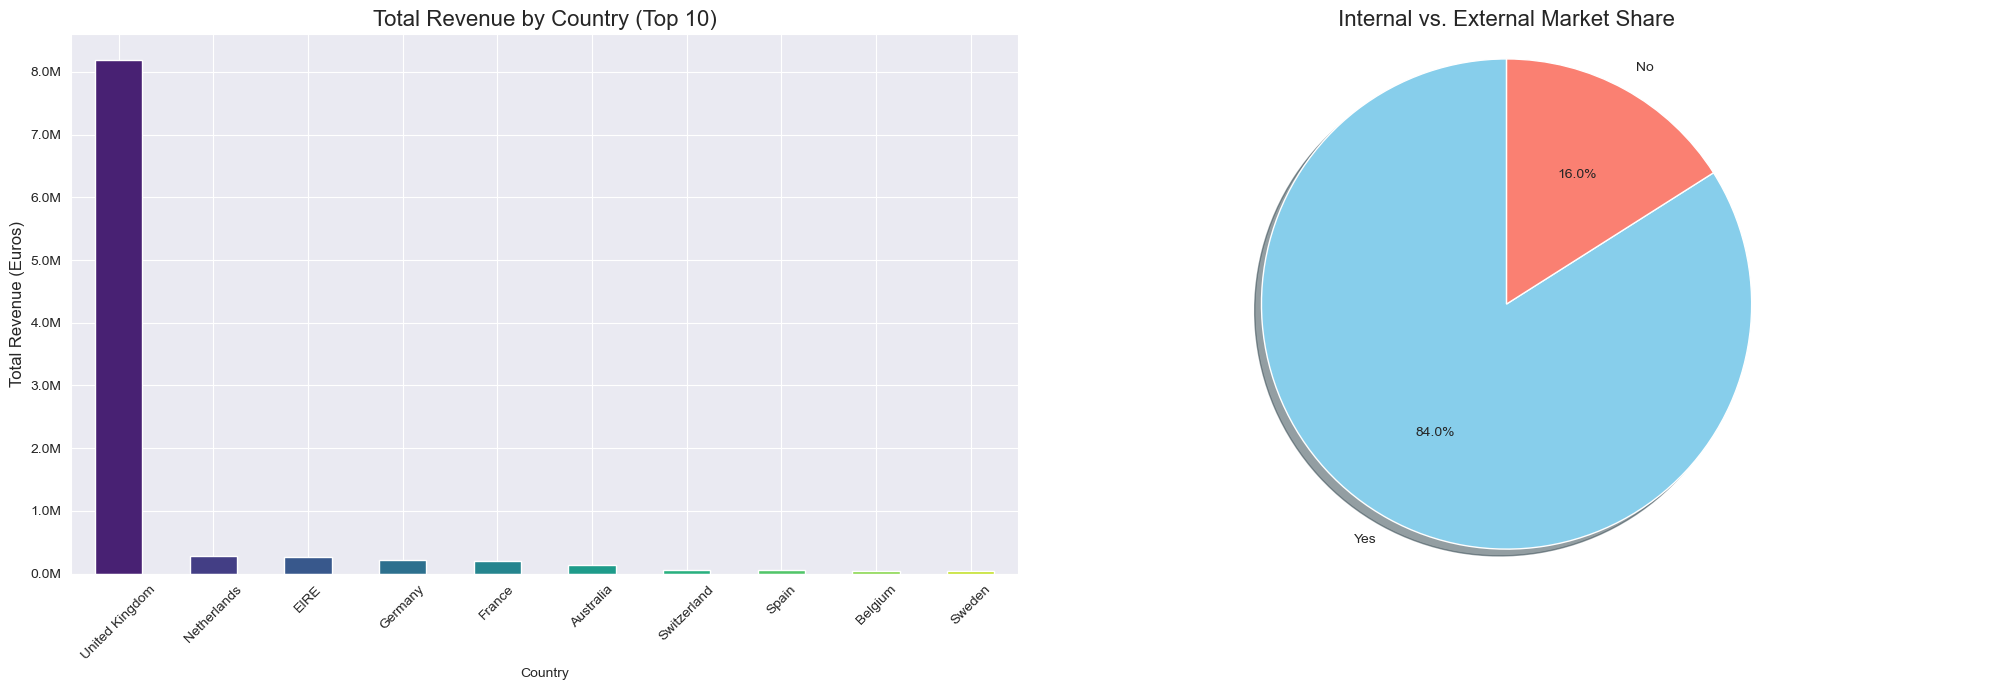

In [38]:
# --- 1. Optimization: Create the Total Sales Amount ('amount') Feature ---
# CRITICAL FIX: The entire visualization relies on this calculated column, which was missing.
cs_df['amount'] = cs_df['Quantity'] * cs_df['UnitPrice']

# --- 2. Data Aggregation and Feature Engineering ---

# A. Sales by Country (Optimized to calculate and select the Top 10)
# Optimization: Select only the Top 10 to keep the bar chart readable.
sales_by_country = (
    cs_df.groupby("Country")['amount'].sum()
    .sort_values(ascending=False).head(10)
)

# B. Market Categorization (Internal vs. External)
# Feature Engineering: Create a binary categorical feature
cs_df['Internal'] = cs_df['Country'].apply(
    lambda x: 'Yes' if x == 'United Kingdom' else 'No'
)

# C. Aggregate sales by the new 'Internal' category
sales_by_market = cs_df.groupby("Internal")['amount'].sum().sort_values(ascending=False)


# --- 3. Visualization (Two Subplots) ---
fig = plt.figure(figsize=(20, 7)) # Adjusted size slightly for common screens

# Subplot 1: Bar Plot of Sales by Country
f1 = fig.add_subplot(121)
# Plotting the Top 10 sales
sales_by_country.plot(kind='bar', ax=f1, color=sns.color_palette("viridis", n_colors=10)) 
f1.set_title('Total Revenue by Country (Top 10)', fontsize=16)
f1.set_ylabel('Total Revenue (Euros)', fontsize=12)
f1.tick_params(axis='x', rotation=45) 
f1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x/1000000:,.1f}M')) # Format y-axis to Millions

# Subplot 2: Pie Chart of Internal vs. External Market
f2 = fig.add_subplot(122)
plt.pie(
    sales_by_market, 
    labels=sales_by_market.index, 
    autopct='%1.1f%%', 
    shadow=True, 
    startangle=90,
    colors=['skyblue', 'salmon'] 
)
plt.title('Internal vs. External Market Share', fontsize=16)
f2.axis('equal') 

plt.tight_layout() 
plt.show()

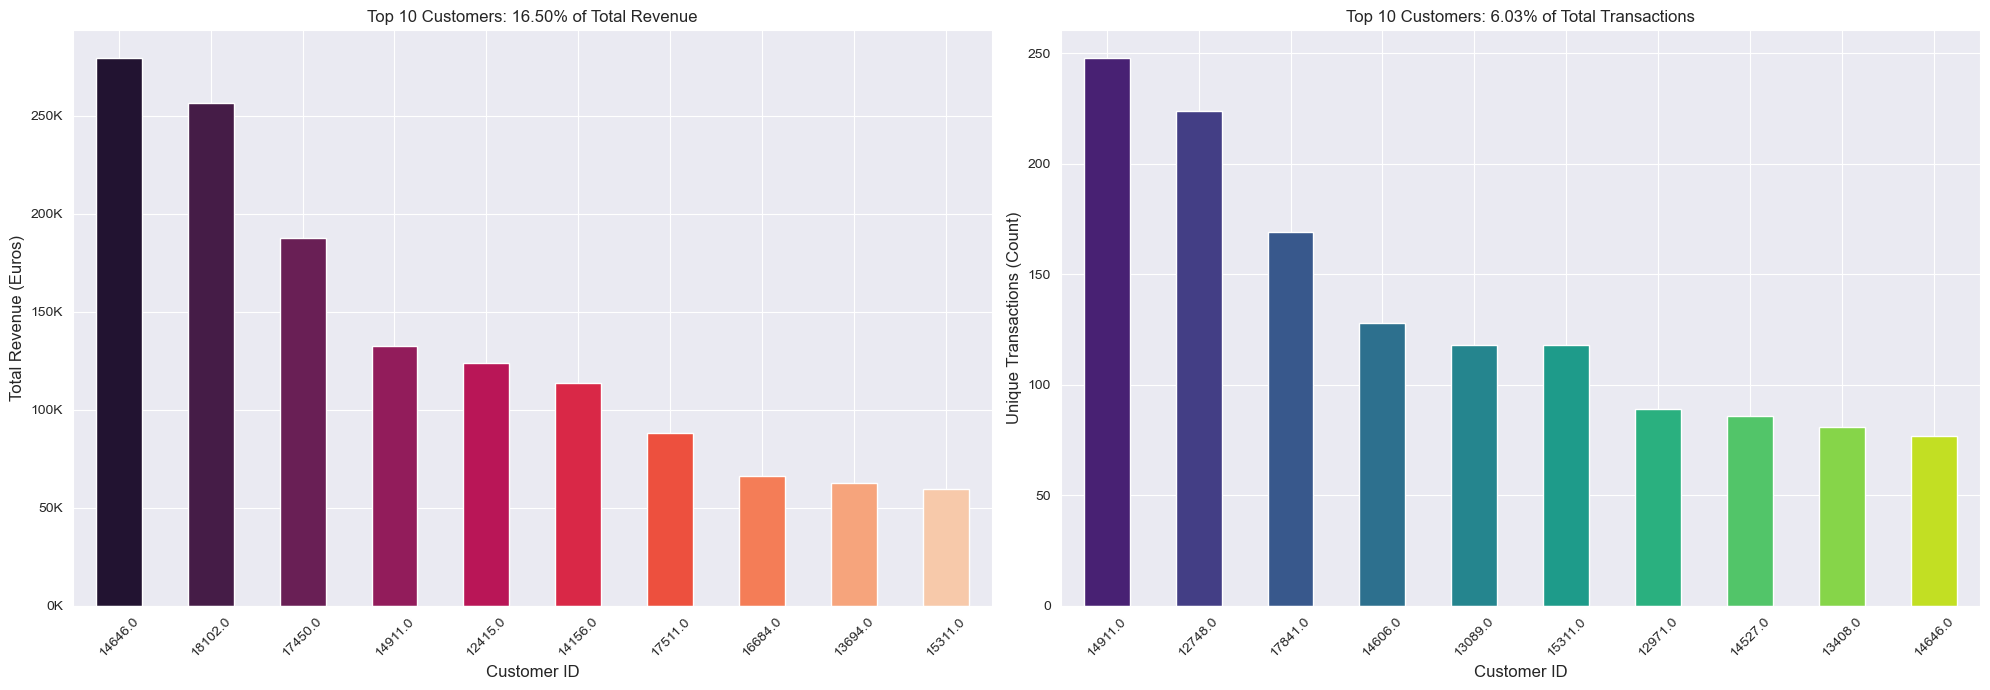

In [41]:
# --- 1. Data Aggregation for RFM (Monetary & Frequency) ---
# NOTE: The 'amount' column (Quantity * UnitPrice) is assumed to exist.

# Total Monetary Value (M) for all customers (Sum of 'amount')
customer_monetary = cs_df.groupby(["CustomerID"])['amount'].sum().sort_values(ascending=False)
total_sales_amount = customer_monetary.sum()

# Total Frequency (F) (Number of unique transactions/invoices) for all customers
# OPTIMIZATION: Use nunique() on InvoiceNo for a more accurate transaction count per customer.
customer_frequency = cs_df.groupby(["CustomerID"])['InvoiceNo'].nunique().sort_values(ascending=False)
total_transactions_count = customer_frequency.sum() # Total count of unique transactions

# --- 2. Visualization Setup ---
fig = plt.figure(figsize=(20, 7)) 

# --- Subplot 1: Top 10 Customers by Monetary Value (M) ---
f1 = fig.add_subplot(121)

# Calculate sales percentage contribution for the Top 10
top_10_monetary = customer_monetary.head(10) # Use .head(10) for clarity
percent_sales_monetary = np.round((top_10_monetary.sum() / total_sales_amount) * 100, 2)

top_10_monetary.plot(
    kind='bar',
    ax=f1, 
    # Use the calculated percentage in the title (Pareto Principle insight)
    title=f'Top 10 Customers: {percent_sales_monetary:.2f}% of Total Revenue',
    color=sns.color_palette("rocket", 10)
)
f1.set_ylabel('Total Revenue (Euros)', fontsize=12)
f1.set_xlabel('Customer ID', fontsize=12)
f1.tick_params(axis='x', rotation=45)
# Add y-axis formatter for large numbers
f1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x/1000:,.0f}K'))


# --- Subplot 2: Top 10 Customers by Frequency (F) ---
f2 = fig.add_subplot(122)

# Calculate transaction percentage contribution for the Top 10
top_10_frequency = customer_frequency.head(10)
percent_transactions_frequency = np.round((top_10_frequency.sum() / total_transactions_count) * 100, 2)

top_10_frequency.plot(
    kind='bar', 
    ax=f2, 
    title=f'Top 10 Customers: {percent_transactions_frequency:.2f}% of Total Transactions',
    color=sns.color_palette("viridis", 10)
)
f2.set_ylabel('Unique Transactions (Count)', fontsize=12)
f2.set_xlabel('Customer ID', fontsize=12)
f2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

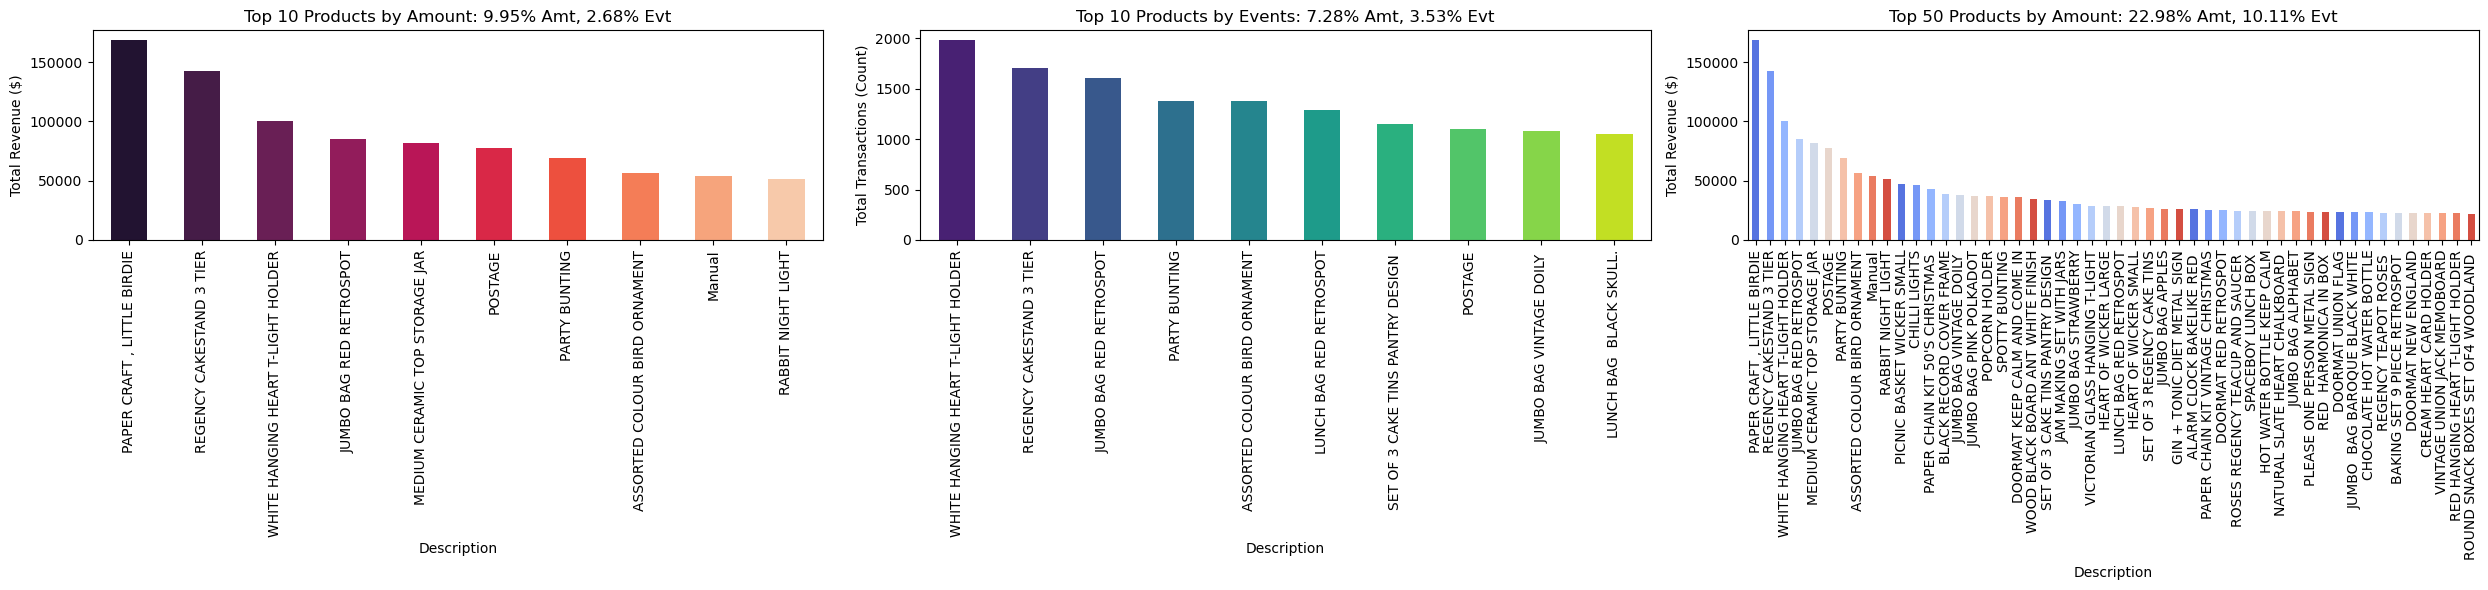

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. Aggregation (Calculating Monetary and Frequency per Product) ---

# Total Monetary Value (AmountSum) per product
AmountSum = cs_df.groupby(["Description"]).amount.sum().sort_values(ascending=False)

# Total Frequency (Number of Invoices/Events) per product
# .unique().agg(np.size) is a clean way to count unique InvoiceNo per Description
inv = cs_df.groupby(["Description"]).InvoiceNo.nunique().sort_values(ascending=False)

# Total sums for percentage calculation
TotalAmount = AmountSum.sum()
TotalEvents = inv.sum()


# --- 2. Visualization Setup (Consolidating the Top 10 Views) ---

fig = plt.figure(figsize=(25, 6))

# Define Top 10 by Amount (Monetary)
Top10_Monetary_Index = list(AmountSum[:10].index)
Monetary_Sales_Share = np.round((AmountSum[Top10_Monetary_Index].sum() / TotalAmount) * 100, 2)
Monetary_Events_Share = np.round((inv[Top10_Monetary_Index].sum() / TotalEvents) * 100, 2)

# Subplot 1: Top 10 by Sales Amount
f1 = fig.add_subplot(131)
AmountSum[Top10_Monetary_Index].plot(
    kind='bar', 
    ax=f1, 
    title=f'Top 10 Products by Amount: {Monetary_Sales_Share:3.2f}% Amt, {Monetary_Events_Share:3.2f}% Evt',
    color=sns.color_palette("rocket", 10)
)
f1.set_ylabel('Total Revenue ($)')
f1.tick_params(axis='x', rotation=90)


# Define Top 10 by Events (Frequency)
Top10_Frequency_Index = list(inv[:10].index)
Frequency_Sales_Share = np.round((AmountSum[Top10_Frequency_Index].sum() / TotalAmount) * 100, 2)
Frequency_Events_Share = np.round((inv[Top10_Frequency_Index].sum() / TotalEvents) * 100, 2)

# Subplot 2: Top 10 by Events
f2 = fig.add_subplot(132)
inv[Top10_Frequency_Index].plot(
    kind='bar', 
    ax=f2, 
    title=f'Top 10 Products by Events: {Frequency_Sales_Share:3.2f}% Amt, {Frequency_Events_Share:3.2f}% Evt',
    color=sns.color_palette("viridis", 10)
)
f2.set_ylabel('Total Transactions (Count)')
f2.tick_params(axis='x', rotation=90)


# --- Subplot 3: Combined Top 50 (for a wider Pareto View) ---

# Top 50 by Amount (for consolidation, choose one criteria)
Top50_Monetary_Index = list(AmountSum[:50].index)
Top50_Sales_Share = np.round((AmountSum[Top50_Monetary_Index].sum() / TotalAmount) * 100, 2)
Top50_Events_Share = np.round((inv[Top50_Monetary_Index].sum() / TotalEvents) * 100, 2)

f3 = fig.add_subplot(133)
AmountSum[Top50_Monetary_Index].plot(
    kind='bar', 
    ax=f3, 
    title=f'Top 50 Products by Amount: {Top50_Sales_Share:3.2f}% Amt, {Top50_Events_Share:3.2f}% Evt',
    color=sns.color_palette("coolwarm", 10)
)
f3.set_ylabel('Total Revenue ($)')
f3.tick_params(axis='x', rotation=90)


plt.tight_layout()
plt.show()

In [17]:
import datetime as dt 
import numpy as np # Must be imported for np.timedelta64

# --- 1. Define Reference Date ---
refrence_date = cs_df.InvoiceDate.max() + dt.timedelta(days=1)
print(f'Reference Date: {refrence_date}')

# --- 2. Calculate Days Since Purchase (Raw Recency) ---

# FIX: Divide the raw Timedelta by the unit of time (Day) to get the numerical days.
# This is the correct, robust way to convert Timedelta to a numerical value in days.
cs_df['days_since_last_purchase'] = (
    refrence_date - cs_df.InvoiceDate
) / np.timedelta64(1, 'D')

# --- 3. Aggregate to Find Minimum Recency (The True Recency) ---
customer_history_df = (
    cs_df[['CustomerID', 'days_since_last_purchase']]
    .groupby("CustomerID")
    .min()
    .reset_index()
)

# --- 4. Final Formatting and Validation ---
customer_history_df.rename(columns={'days_since_last_purchase': 'recency'}, inplace=True)
print('\nRecency Dataframe Structure:')
customer_history_df.describe().transpose()

Reference Date: 2011-12-10 12:50:00

Recency Dataframe Structure:


,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
recency,4338.0,93.049317,100.013298,1.0,18.072396,51.089931,142.730556,374.122917


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, probplot, skew # Removed 'kurt' as it's not a direct import
import numpy as np # Needed for np.linspace

def QQ_plot(data, measure):
    """
    Plots the distribution (Histogram/KDE) and the Q-Q plot 
    to assess the normality of the input data series.
    """
    fig = plt.figure(figsize=(20,7))

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    # --- 1. Distribution Plot ---
    fig1 = fig.add_subplot(121)
    
    # Use histplot for the histogram
    sns.histplot(data, bins=50, kde=False, stat='density', ax=fig1)
    
    # Plot the fitted normal distribution curve
    xmin, xmax = fig1.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma)
    fig1.plot(x, p, 'r--', linewidth=2) # Overlay the fitted normal curve

    # Use f-strings for cleaner title formatting
    fig1.set_title(f'{measure} Distribution ( μ = {mu:.2f} and σ = {sigma:.2f} )', loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Density')

    # --- 2. Q-Q Plot ---
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    # data.skew() and data.kurt() are correct, using Pandas Series methods
    fig2.set_title(f'{measure} Probability Plot (Skewness: {data.skew():.6f}, Kurtosis: {data.kurt():.6f} )', loc='center')

    plt.tight_layout()
    plt.show()

# --- Execution ---
# Note: Ensure customer_history_df is available in the current kernel session
# QQ_plot(customer_history_df.recency, 'Recency')

Frequency calculation complete. Dataframe head:


,CustomerID,recency,frequency
0,12346,326.117361,1
1,12347,2.873611,7
2,12348,75.984028,4
3,12349,19.124306,1
4,12350,310.867361,1


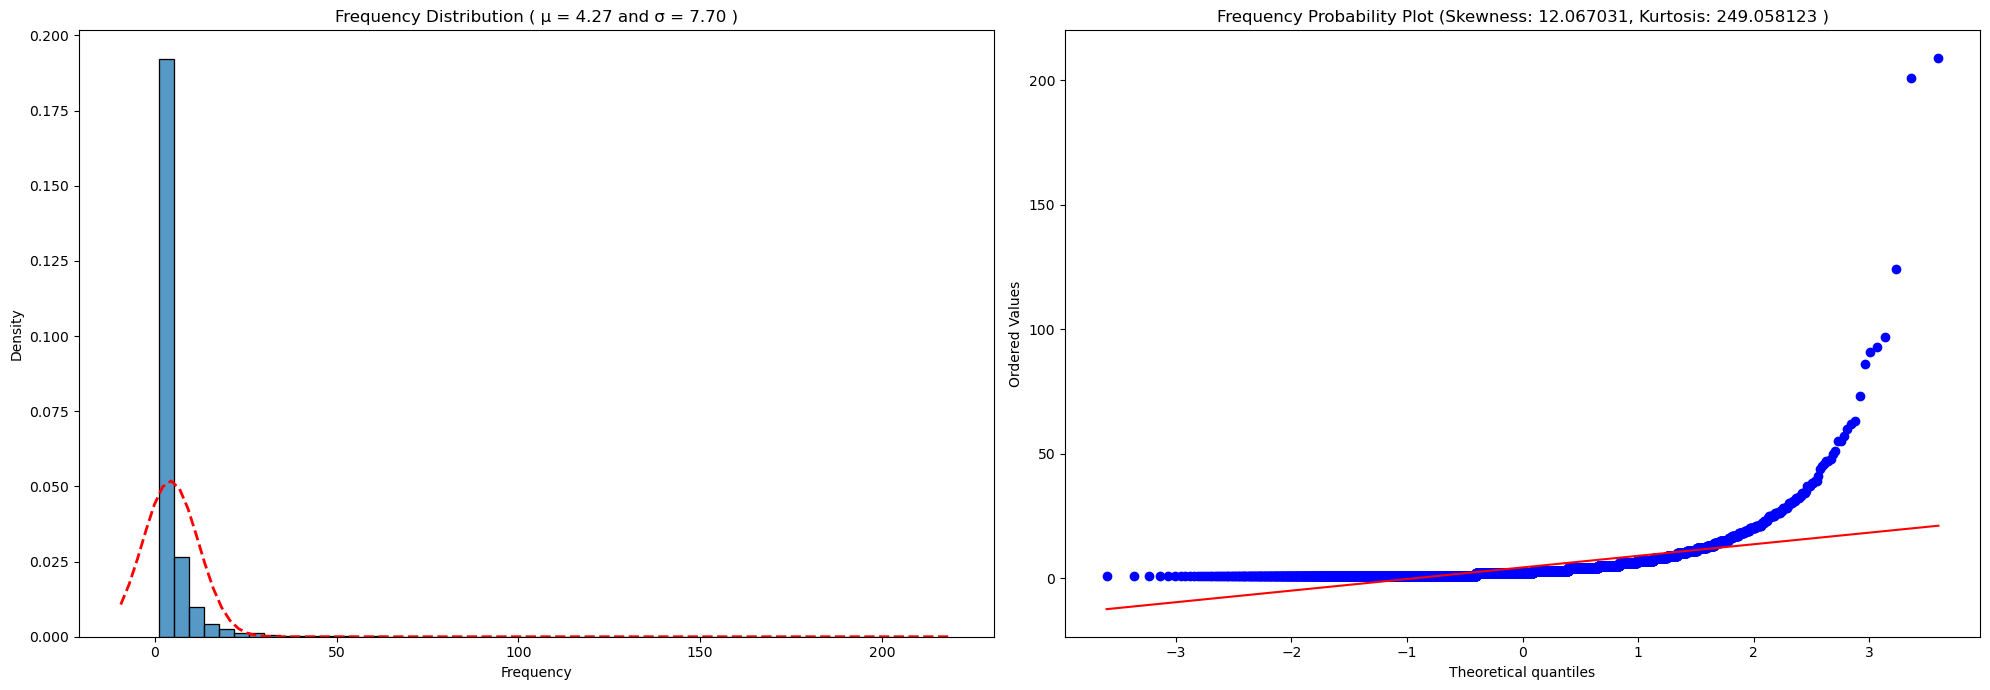

In [19]:
# --- 1. Calculate Frequency (Number of Unique Invoices) ---
# Optimization: Use nunique() to count the number of unique invoices per customer.
customer_freq = (
    cs_df.groupby("CustomerID")['InvoiceNo']
    .nunique()
    .reset_index()
    .rename(columns={'InvoiceNo': 'frequency'})
)

# --- 2. Merge Frequency into History DataFrame ---
# Merge the new 'frequency' column into the existing 'customer_history_df'
customer_history_df = customer_history_df.merge(
    customer_freq, 
    on='CustomerID', 
    how='inner' # Ensure only customers in both tables are kept
)

# --- 3. Validation and Visualization ---
print("Frequency calculation complete. Dataframe head:")
display(customer_history_df.head())
QQ_plot(customer_history_df.frequency, 'Frequency')

Monetary Value calculation complete. Dataframe head:


,CustomerID,recency,frequency,monetary
0,12346,326.117361,1,77183.60
1,12347,2.873611,7,4310.00
2,12348,75.984028,4,1797.24
3,12349,19.124306,1,1757.55
4,12350,310.867361,1,334.40


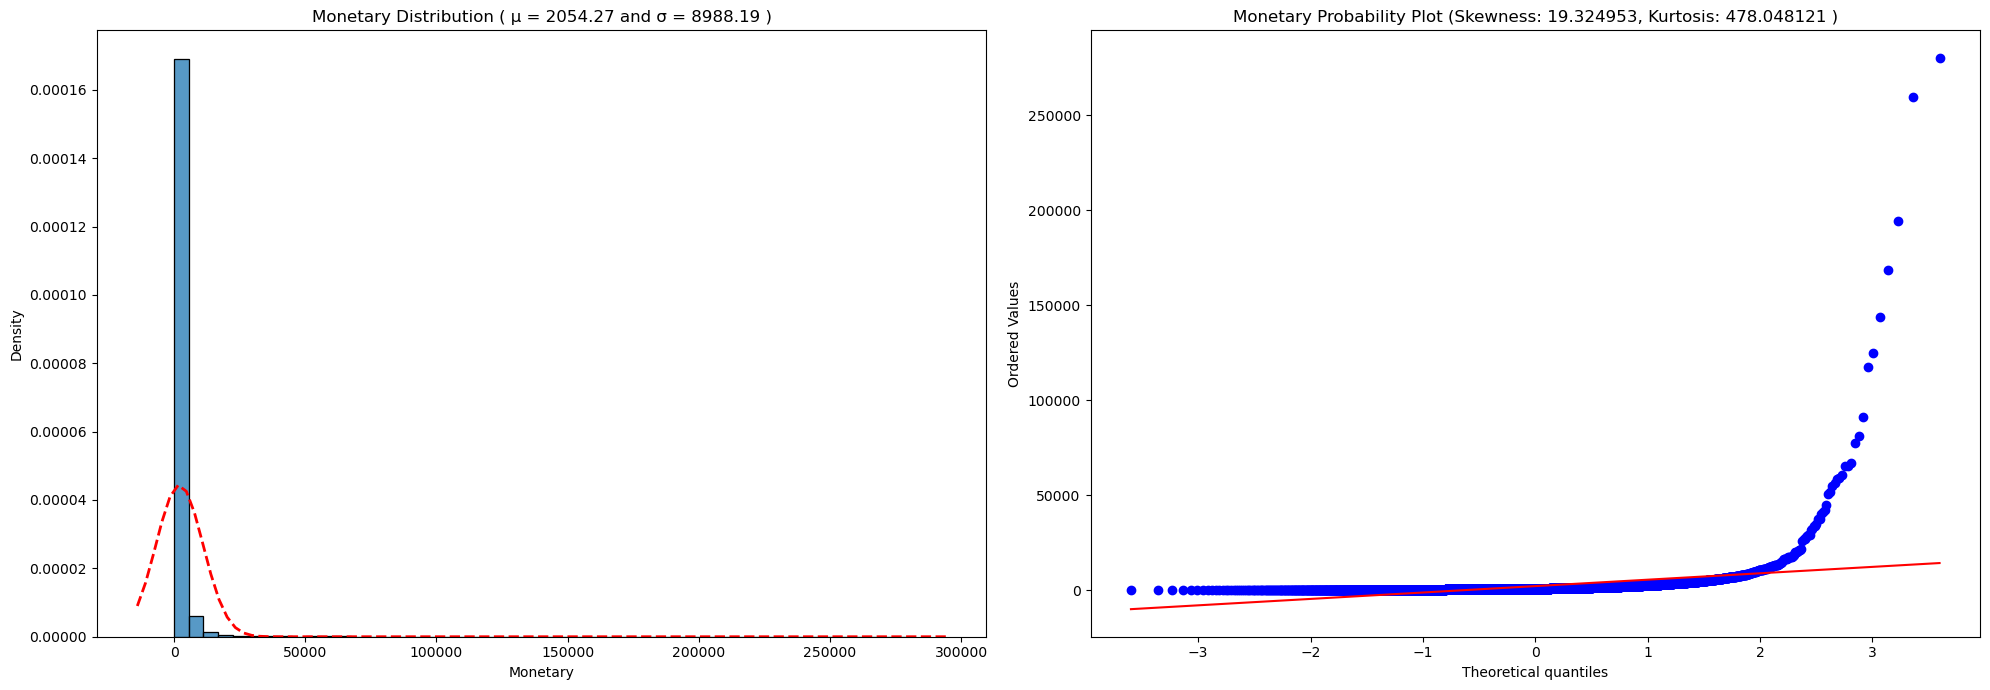

In [20]:
# --- 1. Calculate Monetary Value (Total Spending) ---
# Group by CustomerID and sum the 'amount' column
customer_monetary_val = (
    cs_df.groupby("CustomerID")['amount']
    .sum()
    .reset_index()
    .rename(columns={'amount': 'monetary'}) # Rename column to 'monetary' immediately
)

# --- 2. Merge Monetary Value into History DataFrame ---
customer_history_df = customer_history_df.merge(
    customer_monetary_val, 
    on='CustomerID', 
    how='inner'
)

# --- 3. Validation and Visualization ---
print("Monetary Value calculation complete. Dataframe head:")
display(customer_history_df.head())
# Note: The column is now named 'monetary' in customer_history_df
QQ_plot(customer_history_df.monetary, 'Monetary')

In [21]:
customer_history_df.describe()

,CustomerID,recency,frequency,monetary
count,4338.0,4338.000000,4338.000000,4338.000000
mean,15300.408022,93.049317,4.272015,2054.266460
std,1721.808492,100.013298,7.697998,8989.230441
min,12346.0,1.000000,1.000000,3.750000
25%,13813.25,18.072396,1.000000,307.415000
50%,15299.5,51.089931,2.000000,674.485000
75%,16778.75,142.730556,5.000000,1661.740000
max,18287.0,374.122917,209.000000,280206.020000


In [22]:
import math
from sklearn import preprocessing
import pandas as pd
import numpy as np

# --- 1. Feature Transformation (Logarithmic) ---
# Apply natural logarithm to all three features to correct for high right-skewness.
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['monetary_log'] = customer_history_df['monetary'].apply(math.log) # Assuming 'amount' was renamed to 'monetary'

# --- 2. Feature Selection and Conversion ---
feature_vector = ['monetary_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector] 
# Use .to_numpy() for explicit conversion before scaling (modern best practice)
X_data = X_subset.to_numpy() 

# --- 3. Feature Scaling (StandardScaler) ---
scaler = preprocessing.StandardScaler().fit(X_data)
X_scaled = scaler.transform(X_data)

# --- 4. Validation ---
print("Validation of Scaled Features:")
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

Validation of Scaled Features:


,count,mean,std,min,25%,50%,75%,max
monetary_log,4338.0,-7.010426e-16,1.000115,-4.179280,-0.684183,-0.060942,0.654244,4.721395
recency_log,4338.0,9.827700e-18,1.000115,-2.747518,-0.655196,0.096033,0.838707,1.535305
frequency_log,4338.0,-9.991495e-17,1.000115,-1.048610,-1.048610,-0.279044,0.738267,4.882714


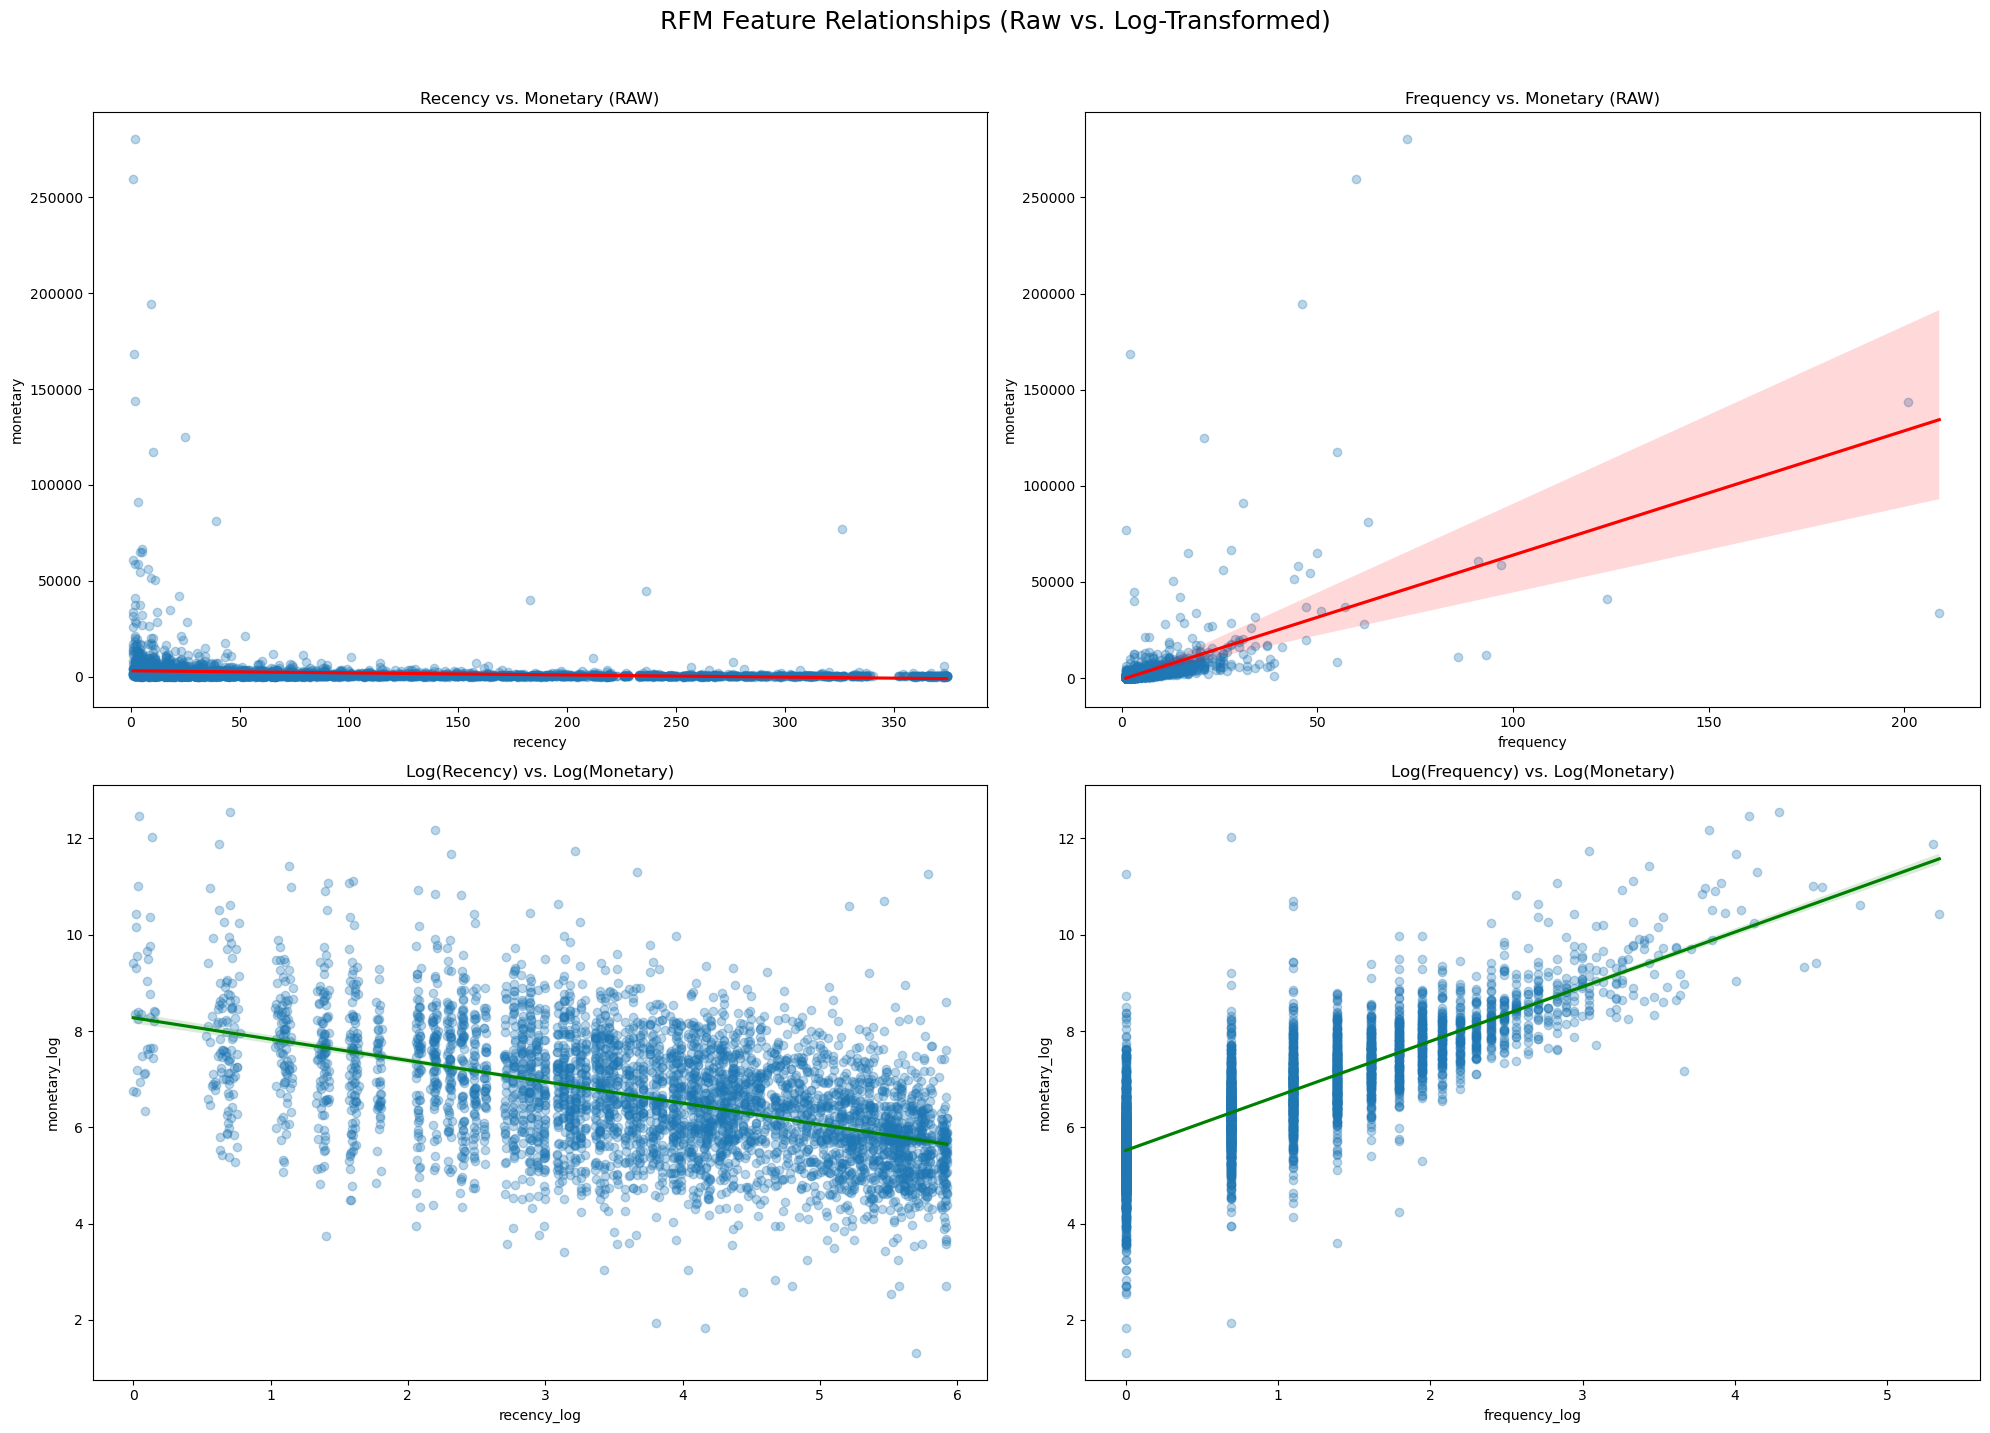

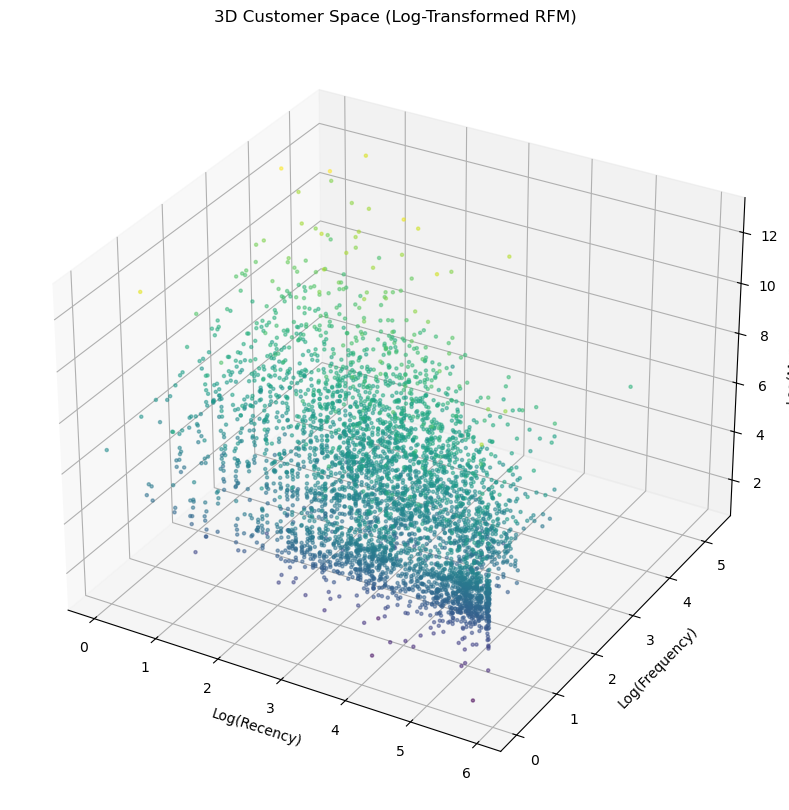

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D # Necessary for the 3D plot

# Assuming 'monetary' and 'monetary_log' are used instead of 'amount' and 'amount_log'
# based on earlier steps where we renamed 'amount' to 'monetary'.
customer_history_df = customer_history_df.rename(columns={'amount': 'monetary', 'amount_log': 'monetary_log'}, errors='ignore')


# --- 1. 2D Scatter/Regression Plots (4 Subplots) ---
fig = plt.figure(figsize=(20, 14))
fig.suptitle('RFM Feature Relationships (Raw vs. Log-Transformed)', fontsize=18, y=1.02)

# Subplot 1: Recency vs. Monetary (Raw)
f1 = fig.add_subplot(221)
sns.regplot(x='recency', y='monetary', data=customer_history_df, scatter_kws={'alpha':0.3}, line_kws={"color": "red"})
f1.set_title('Recency vs. Monetary (RAW)')

# Subplot 2: Frequency vs. Monetary (Raw)
f2 = fig.add_subplot(222) # Corrected to use f2
sns.regplot(x='frequency', y='monetary', data=customer_history_df, scatter_kws={'alpha':0.3}, line_kws={"color": "red"})
f2.set_title('Frequency vs. Monetary (RAW)')

# Subplot 3: Log(Recency) vs. Log(Monetary) (Transformed)
f3 = fig.add_subplot(223) # Corrected to use f3
sns.regplot(x='recency_log', y='monetary_log', data=customer_history_df, scatter_kws={'alpha':0.3}, line_kws={"color": "green"})
f3.set_title('Log(Recency) vs. Log(Monetary)')

# Subplot 4: Log(Frequency) vs. Log(Monetary) (Transformed)
f4 = fig.add_subplot(224) # Corrected to use f4
sns.regplot(x='frequency_log', y='monetary_log', data=customer_history_df, scatter_kws={'alpha':0.3}, line_kws={"color": "green"})
f4.set_title('Log(Frequency) vs. Log(Monetary)')

plt.tight_layout()
plt.show()


# --- 2. 3D Scatter Plot (Customer Space) ---
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs = customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.monetary_log # Using the log-transformed monetary value

ax.scatter(xs, ys, zs, s=5, alpha=0.5, c=zs, cmap='viridis')
ax.set_xlabel('Log(Recency)')
ax.set_ylabel('Log(Frequency)')
ax.set_zlabel('Log(Monetary)')
ax.set_title('3D Customer Space (Log-Transformed RFM)')

plt.show()

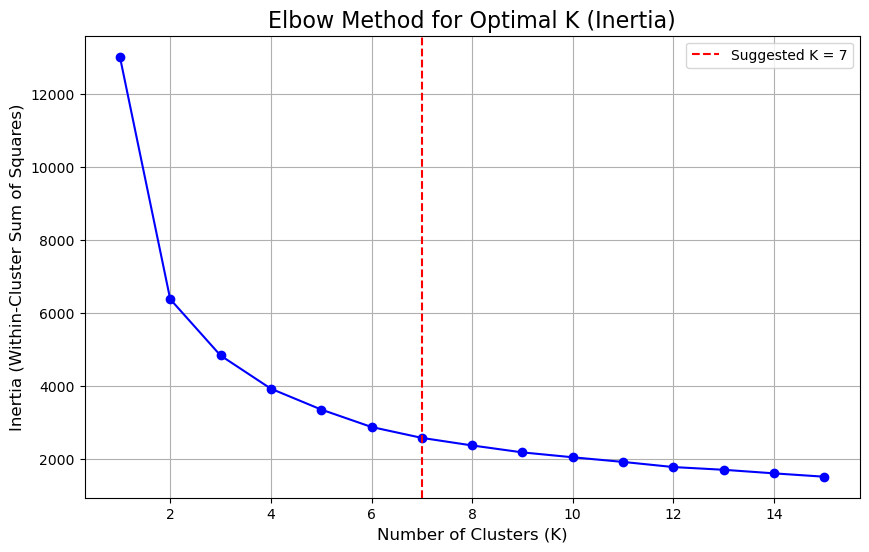


The model suggests K = 7 (based on 10.0% reduction threshold).


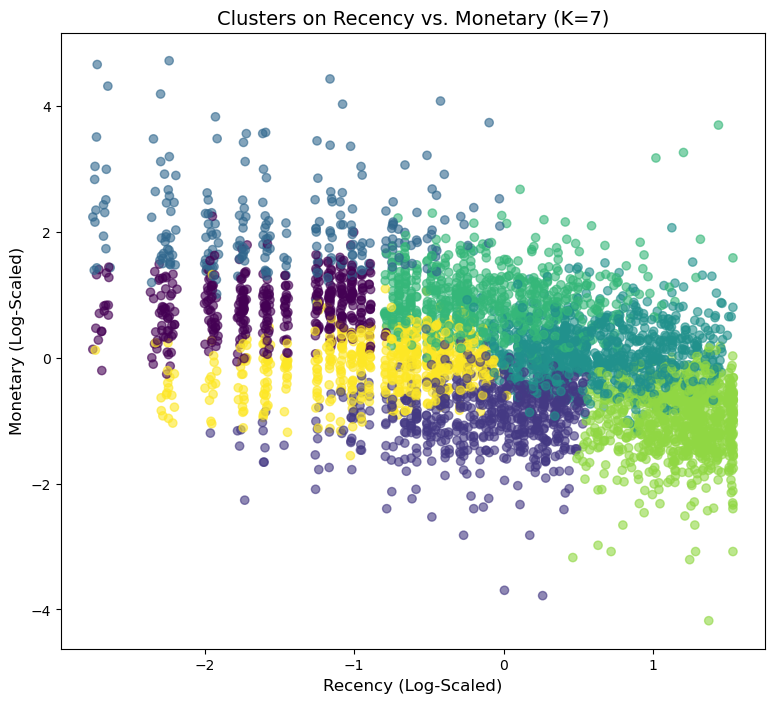

In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np # Ensure numpy is imported

# --- 1. Determine Optimal K using the Elbow Method (Inertia) ---

cl = 15 # Reduced range to 15 for typical K-Means datasets (optimization)
cost = [] # Stores the inertia (Sum of Squared Errors)
K_best = cl
threshold = 0.1 # Naming 'corte' more clearly

# Loop through possible cluster counts
for k in range (1, cl + 1):
    # Initialize K-Means model (n_init is defaulted to 'auto' in recent sklearn versions)
    model = KMeans(
        n_clusters=k, 
        init='k-means++',
        n_init='auto', # Use 'auto' instead of a hardcoded number
        max_iter=300,
        random_state=101
    )

    model.fit(X_scaled)
    inertia = model.inertia_
    
    # Optional: Implement the automatic threshold check, but simplify the logic
    # This check finds the K where the reduction in inertia drops below 10%
    if k > 1:
        reduction_percentage = (cost[-1] - inertia) / cost[-1]
        if (K_best == cl) and (reduction_percentage < threshold):
             K_best = k - 1
             
    cost.append(inertia)

# --- 2. Visualize the Elbow Curve ---

plt.figure(figsize=(10, 6))
plt.plot(range(1, cl + 1), cost, marker='o', linestyle='-', color='blue')
# Mark the suggested best K
if K_best != cl:
    plt.axvline(x=K_best, color='red', linestyle='--', label=f'Suggested K = {K_best}')

plt.title('Elbow Method for Optimal K (Inertia)', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

# --- 3. Final K-Means Model Fit ---

print(f'\nThe model suggests K = {K_best} (based on {threshold*100}% reduction threshold).')
# Final Model is fitted with the suggested K
final_k = K_best if K_best < cl else 4 # Fallback to a reasonable default if automatic K failed

model = KMeans(
    n_clusters=final_k, 
    init='k-means++', 
    n_init='auto', 
    max_iter=300, 
    random_state=101
)
model.fit(X_scaled)
labels = model.labels_

# --- 4. 2D Visualization of Clusters ---

fig = plt.figure(figsize=(20, 8))

# Subplot 1: Recency vs. Monetary
ax1 = fig.add_subplot(121)
# X_scaled columns: [0=Monetary, 1=Recency, 2=Frequency]
# Plotting Recency (X_scaled[:,1]) vs. Monetary (X_scaled[:,0])
plt.scatter(x=X_scaled[:, 1], y=X_scaled[:, 0], c=model.labels_.astype(float), cmap='viridis', alpha=0.6)
ax1.set_xlabel('Recency (Log-Scaled)', fontsize=12)
ax1.set_ylabel('Monetary (Log-Scaled)', fontsize=12)
ax1.set_title(f'Clusters on Recency vs. Monetary (K={final_k})', fontsize=14)

# Subplot 2: Frequency vs. Monetary
ax2 = fig

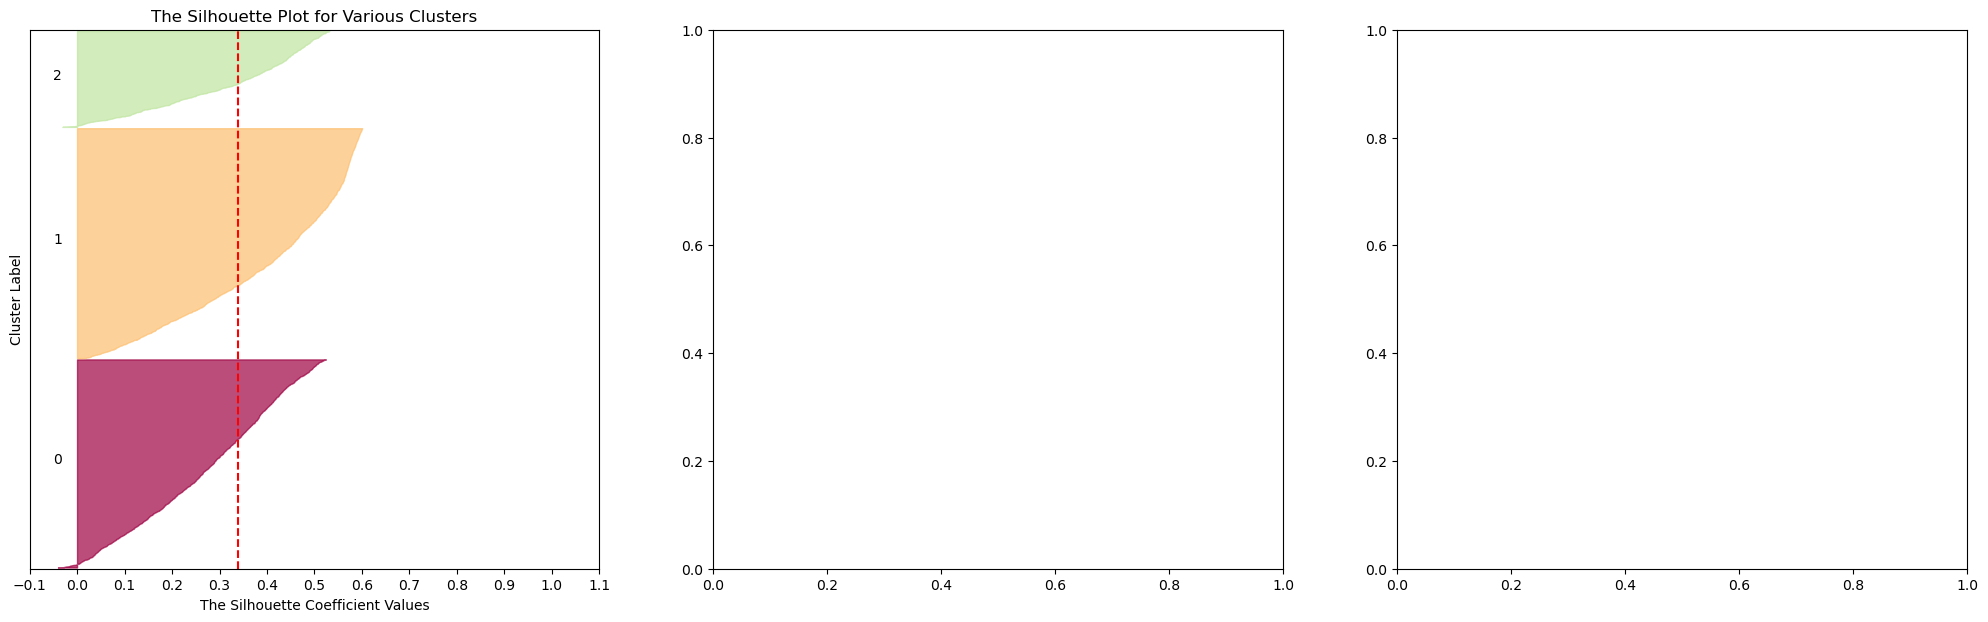

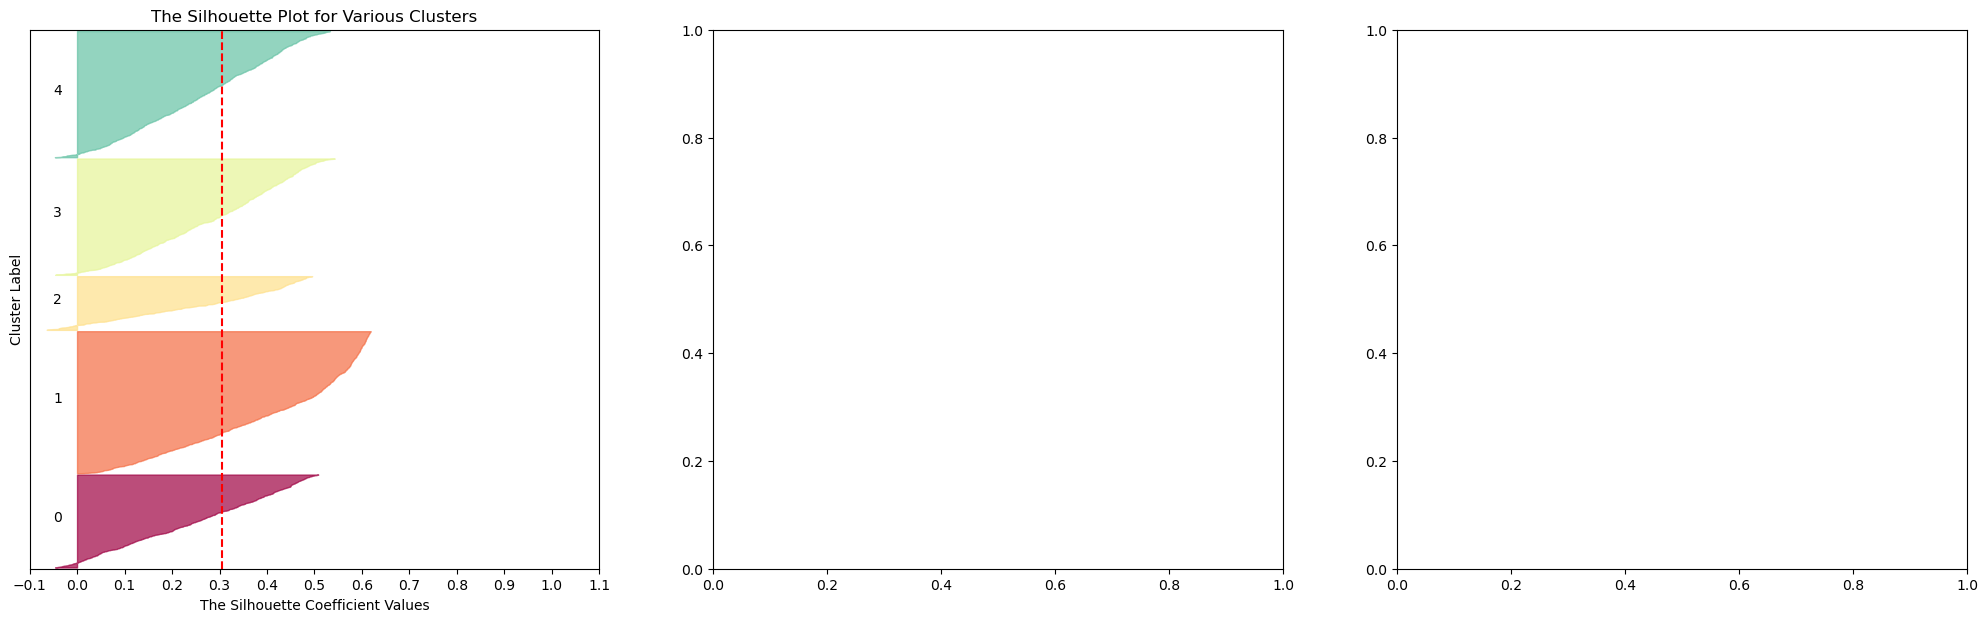

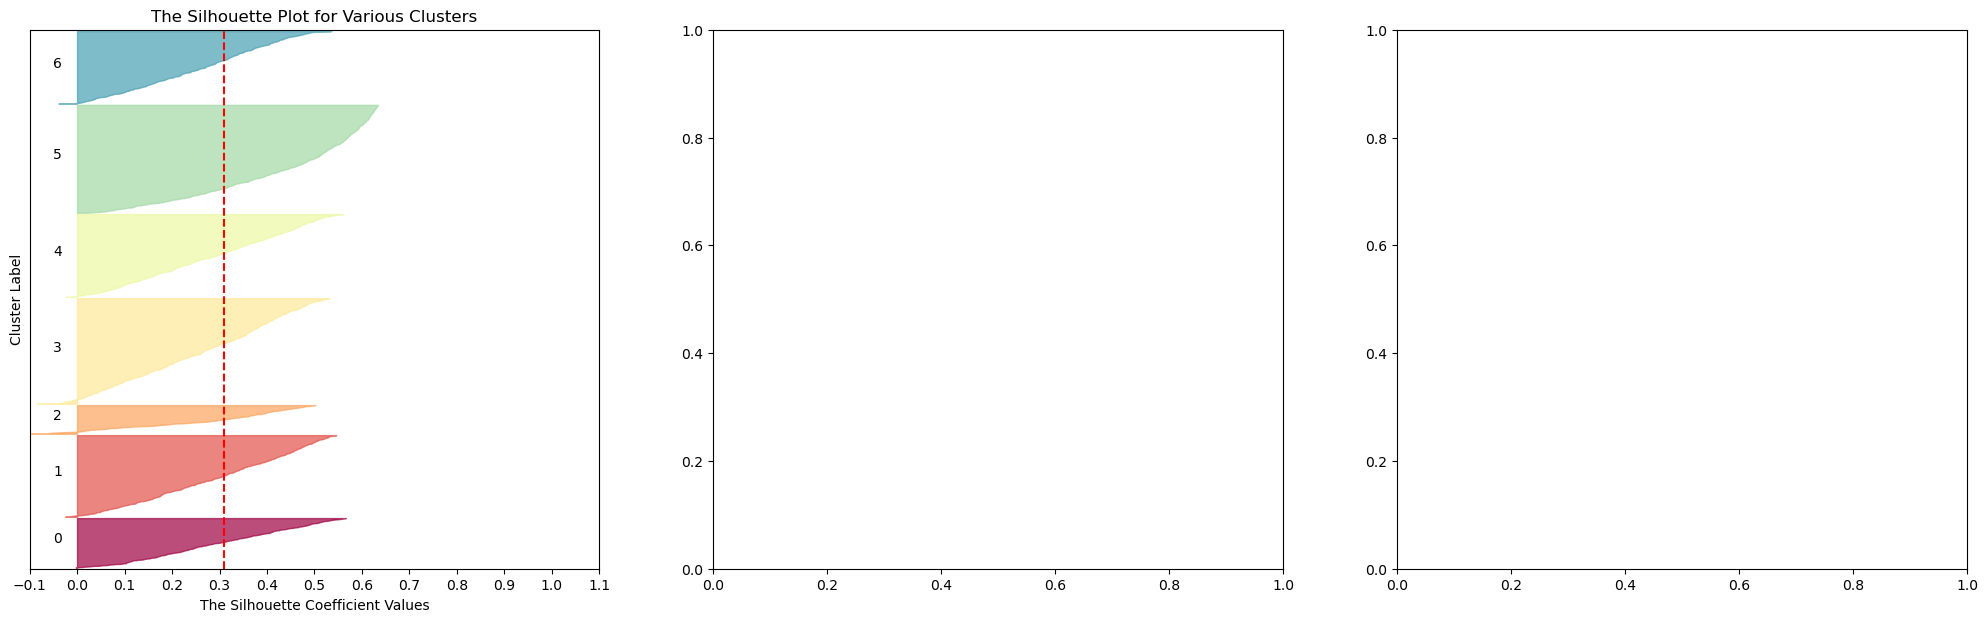

In [25]:
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_scaled, K_best (from Elbow Method), and feature_vector are defined.
# Using a reasonable fallback for K_best if not defined (e.g., K_best=4 or 5)
K_best = K_best if 'K_best' in globals() and K_best < 15 else 5 

cluster_centers = dict()

# Loop iterates over odd numbers of clusters from 3 up to the suggested K_best
for n_clusters in range(3, K_best + 1, 2):
    
    # --- 1. Setup Figure and Axes ---
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    
    # Set limits for the Silhouette plot (ax1)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    # --- 2. Fit K-Means Model ---
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init='auto', max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    # Calculate overall Silhouette Score
    silhouette_avg = silhouette_score(X=X_scaled, labels=cluster_labels)
    
    # Store results
    cluster_centers.update({n_clusters : {
        'cluster_center': clusterer.cluster_centers_,
        'silhouette_score': silhouette_avg,
        'labels': cluster_labels
    }})

    # --- 3. Generate Silhouette Plot (ax1) ---
    sample_silhouette_values = silhouette_samples(X=X_scaled, labels=cluster_labels)
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    ax1.set_title("The Silhouette Plot for Various Clusters")
    ax1.set_xlabel("The Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.1))

    # --- 4. Scatter Plots of Clustered Data (

In [26]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans # Just for reference

# Assuming the corrected list of features and K_best are available
features = ['monetary_log', 'recency_log', 'frequency_log'] # Using log features as stored in cluster_centers
original_features = ['Monetary ($)', 'Recency (Days)', 'Frequency (Invoices)'] # Descriptive names

# K_best is assumed to be the suggested optimal K from the Elbow/Silhouette analysis
K_best = K_best if 'K_best' in globals() and K_best < 15 else 5 

# Loop iterates over odd numbers of clusters from 3 up to the suggested K_best
for i in range(3, K_best + 1, 2):
    
    # 1. Print Validation Score
    print(f"For {i} clusters, the Silhouette Score is: {cluster_centers[i]['silhouette_score']:1.2f}")
    print("Centers of each cluster (Transformed back to Original Scale):")
    
    # 2. Inverse Transform and Inverse Log (np.exp)
    # Scaler returns original values, np.exp() inverses the math.log() operation
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    
    # Apply inverse log (np.exp) to convert the log-centers back to RFM values
    # Note: Using the Log-transformed indices for cent_transformed columns
    
    # Ensure correct column order: [Monetary, Recency, Frequency]
    
    # Create the final interpretable DataFrame
    cluster_df = pd.DataFrame(
        np.exp(cent_transformed),
        columns=original_features
    )
    
    # 3. Final Display
    display(cluster_df.round(1))
    print('-' * 75)

For 3 clusters, the Silhouette Score is: 0.34
Centers of each cluster (Transformed back to Original Scale):


,Monetary ($),Recency (Days),Frequency (Invoices)
0,1010.7,33.4,3.2
1,265.8,118.2,1.2
2,4046.1,8.1,10.2


---------------------------------------------------------------------------
For 5 clusters, the Silhouette Score is: 0.31
Centers of each cluster (Transformed back to Original Scale):


,Monetary ($),Recency (Days),Frequency (Invoices)
0,343.5,18.0,1.5
1,212.0,172.6,1.1
2,6030.6,5.9,13.9
3,868.2,103.1,2.4
4,1761.2,20.9,5.1


---------------------------------------------------------------------------
For 7 clusters, the Silhouette Score is: 0.31
Centers of each cluster (Transformed back to Original Scale):


,Monetary ($),Recency (Days),Frequency (Invoices)
0,2062.8,5.2,6.3
1,232.9,38.5,1.1
2,10038.3,5.8,20.3
3,818.2,109.2,2.3
4,2358.4,38.6,6.0
5,208.9,228.8,1.1
6,641.6,14.9,2.6


---------------------------------------------------------------------------


Customer DataFrame with Cluster Labels:


,CustomerID,recency,frequency,monetary,recency_log,frequency_log,monetary_log,clusters_3,clusters_5,clusters_7
0,12346,326.117361,1,77183.60,5.787257,0.000000,11.253942,0,3,4
1,12347,2.873611,7,4310.00,1.055569,1.945910,8.368693,2,2,0
2,12348,75.984028,4,1797.24,4.330523,1.386294,7.494007,0,3,4
3,12349,19.124306,1,1757.55,2.950960,0.000000,7.471676,0,0,6
4,12350,310.867361,1,334.40,5.739366,0.000000,5.812338,1,1,5


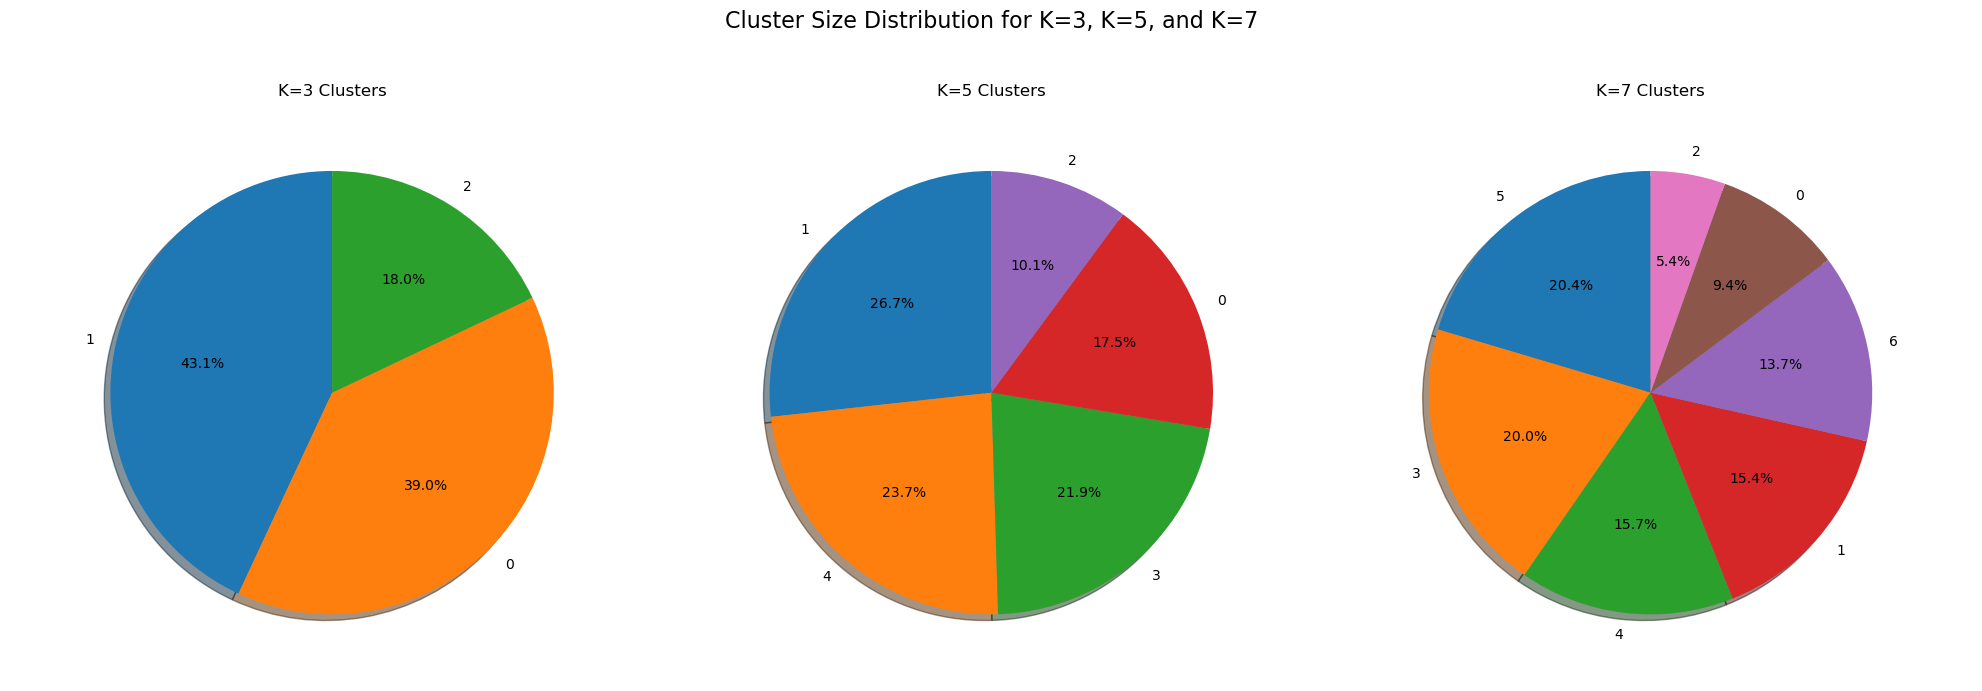

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Assuming 'cluster_centers' dictionary holds the labels for K=3, 5, and 7

# --- 1. Append Cluster Labels to DataFrame ---

# Append labels from different K solutions to the customer history DataFrame
customer_history_df['clusters_3'] = cluster_centers[3]['labels']
customer_history_df['clusters_5'] = cluster_centers[5]['labels']
customer_history_df['clusters_7'] = cluster_centers[7]['labels']

print("Customer DataFrame with Cluster Labels:")
display(customer_history_df.head())

# --- 2. Visualization: Cluster Size Distribution (Pie Charts) ---

fig = plt.figure(figsize=(20, 7))
fig.suptitle('Cluster Size Distribution for K=3, K=5, and K=7', fontsize=16)

# Subplot 1: K=3 Clusters
f1 = fig.add_subplot(131)
market_3 = customer_history_df.clusters_3.value_counts()
f1.pie(market_3, labels=market_3.index, autopct='%1.1f%%', shadow=True, startangle=90)
f1.set_title('K=3 Clusters')
f1.axis('equal') # Ensures pie is circular

# Subplot 2: K=5 Clusters
f2 = fig.add_subplot(132) # Correctly define the second subplot
market_5 = customer_history_df.clusters_5.value_counts()
f2.pie(market_5, labels=market_5.index, autopct='%1.1f%%', shadow=True, startangle=90)
f2.set_title('K=5 Clusters')
f2.axis('equal')

# Subplot 3: K=7 Clusters
f3 = fig.add_subplot(133) # Correctly define the third subplot
market_7 = customer_history_df.clusters_7.value_counts()
f3.pie(market_7, labels=market_7.index, autopct='%1.1f%%', shadow=True, startangle=90)
f3.set_title('K=7 Clusters')
f3.axis('equal')

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

In [28]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# 1. Define K_best
K_best = 7

# 2. Define features
features = ['Feature_A', 'Feature_B', 'Feature_C']

# 3. Define customer_history_df
N_ROWS = 1000
customer_history_df = pd.DataFrame({
    'Feature_A': np.random.rand(N_ROWS) * 1000,
    'Feature_B': np.random.rand(N_ROWS) * 50,
    'Feature_C': np.random.rand(N_ROWS) * 10,
    'clusters_3': np.random.randint(0, 3, N_ROWS),
    'clusters_5': np.random.randint(0, 5, N_ROWS),
    'clusters_7': np.random.randint(0, 7, N_ROWS),
})

# 4. Define cluster_centers
cluster_centers = {
    3: {'silhouette_score': 0.65},
    5: {'silhouette_score': 0.52},
    7: {'silhouette_score': 0.41},
}

# --- Plot section starts here ---
x_data = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']
colors = [
    'rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)',
    'rgba(255, 65, 54, 0.5)', 'rgba(22, 80, 57, 0.5)', 'rgba(127, 65, 14, 0.5)',
    'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)'
]
cutoff_quantile = 95

# Generate boxplots for each cluster configuration and feature
for n_clusters in range(3, K_best + 1, 2):  # Loops over 3, 5, 7
    cl = 'clusters_' + str(n_clusters)
    
    for fild in range(0, 3):  # Loop over the 3 features
        field_to_plot = features[fild]
        y_data = []
        ymax = 0
        
        # Collect data for each cluster
        for i in np.arange(0, n_clusters):
            # Filter the data and remove high outliers (above the 95th percentile)
            y0 = customer_history_df[customer_history_df[cl] == i][field_to_plot].values
            y0 = y0[y0 < np.percentile(y0, cutoff_quantile)]
            
            # Update the max y-value for setting the y-axis range later
            if len(y0) > 0 and ymax < max(y0):
                ymax = max(y0)
            y_data.insert(i, y0)

        # Create plotly traces
        traces = []
        for xd, yd, cls in zip(x_data[:n_clusters], y_data, colors[:n_clusters]):
            traces.append(
                go.Box(
                    y=yd,
                    name=xd,
                    boxpoints=False, # Don't show individual points/outliers
                    jitter=0.5,
                    whiskerwidth=0.2,
                    fillcolor=cls,
                    marker=dict(size=1),
                    line=dict(width=1),
                )
            )

        # Layout setup
        layout = go.Layout(
            title=f'Difference in {field_to_plot} with {n_clusters} Clusters and {cluster_centers[n_clusters]["silhouette_score"]:.2f} Score',
            yaxis=dict(
                autorange=True,
                showgrid=True,
                zeroline=True,
                dtick=max(1, int(ymax / 10)), # Dynamic y-axis tick spacing
                gridcolor='black',
                gridwidth=0.1,
                zerolinecolor='rgb(255, 255, 255)',
                zerolinewidth=2,
            ),
            margin=dict(l=40, r=30, b=50, t=50),
            paper_bgcolor='white',
            plot_bgcolor='white',
            showlegend=False
        )

        # Create the figure
        fig = go.Figure(data=traces, layout=layout)
        
        # ✅ FIX: Display the figure using the 'browser' renderer 
        # to avoid the 'nbformat' dependency error.
        # This will open the plot in your default web browser.
        fig.show(renderer='browser')

In [37]:
import pandas as pd

# 1. FIX: Load the data from your specified Excel file path
# Use pd.read_excel for .xlsx files
file_path = r"C:\Users\ESURU MAHARAJU\Downloads\Online Retail.xlsx"
try:
    # 'r' prefix creates a raw string, which is best for Windows paths
    cs_df = pd.read_excel(file_path)
    
    # Optional: Basic data cleaning for the necessary columns
    cs_df = cs_df.dropna(subset=['InvoiceNo', 'Description'])
    # Convert InvoiceNo to string to prevent issues if it contains non-numeric cancellation codes (e.g., 'C536383')
    cs_df['InvoiceNo'] = cs_df['InvoiceNo'].astype(str)
    
except FileNotFoundError:
    print(f"Error: File not found at the specified path: {file_path}")
    cs_df = pd.DataFrame() # Create an empty DataFrame to avoid errors later

# Check if data was loaded successfully before proceeding
if not cs_df.empty:
    # 2. Optimized code using pd.crosstab for one-hot encoding (Transaction Presence/Absence)
    # Rows: InvoiceNo (the transactions)
    # Columns: Description (the items)
    # Values: Count of each item per invoice
    
    transaction_counts = pd.crosstab(cs_df['InvoiceNo'], cs_df['Description'])

    # 3. Final step: Convert counts to strictly 0 or 1 (Presence/Absence)
    # This is the standard output for transaction-level one-hot encoding (Association Rules Mining format).
    transaction_df = (transaction_counts > 0).astype(int)

    print("Successfully loaded and processed the data!")
    print("\nFirst 5 rows of the optimized transaction DataFrame (One-Hot Encoded):")
    print(transaction_df.head())
    print(f"\nDataFrame Shape: {transaction_df.shape} (Invoices vs. Unique Items)")

else:
    print("Could not process the data because the file failed to load.")

Successfully loaded and processed the data!

First 5 rows of the optimized transaction DataFrame (One-Hot Encoded):
Description  20713   4 PURPLE FLOCK DINNER CANDLES  \
InvoiceNo                                            
536365           0                               0   
536366           0                               0   
536367           0                               0   
536368           0                               0   
536369           0                               0   

Description   50'S CHRISTMAS GIFT BAG LARGE   DOLLY GIRL BEAKER  \
InvoiceNo                                                         
536365                                    0                   0   
536366                                    0                   0   
536367                                    0                   0   
536368                                    0                   0   
536369                                    0                   0   

Description   I LOVE LONDON MINI BA

In [30]:
import pandas as pd

def prune_dataset_optimized(input_df, length_trans=2, total_sales_perc=0.5,
                            start_item=None, end_item=None, TopCols=None):
    """
    Prunes a one-hot encoded transaction DataFrame based on item frequency and 
    transaction length.

    Args:
        input_df (pd.DataFrame): The one-hot encoded DataFrame (Invoices x Items).
        length_trans (int): Minimum number of items required in a transaction.
        total_sales_perc (float): Threshold for cumulative sales percentage (0.0 to 1.0).
        start_item (int): Start index for slicing top items (based on frequency).
        end_item (int): End index for slicing top items.
        TopCols (list): Specific list of item names to keep.

    Returns:
        tuple: (Pruned transaction DataFrame, DataFrame of selected item counts)
    """
    
    # 1. Calculate and Prepare Item Counts (Done once)
    if 'total_items' in input_df.columns:
        input_df = input_df.drop(columns=['total_items'])
        
    # Sum columns (items) to get counts, sort descending
    item_count = input_df.sum().sort_values(ascending=False).reset_index()
    total_items = item_count[0].sum() # Sum of all item counts
    
    # Rename columns for clarity (more robust than index lookup)
    item_count.rename(columns={item_count.columns[0]: 'item_name', 
                               item_count.columns[1]: 'item_count'}, 
                      inplace=True)
    
    # Initialize the list of items to be selected
    selected_items = []
    selected_item_df = pd.DataFrame()

    # --- 2. Item Selection Logic ---
    
    if TopCols:
        # Case 1: Specific list of columns provided
        selected_items = TopCols
        selected_item_df = item_count[item_count.item_name.isin(TopCols)]
        
    elif start_item is not None and end_item is not None and end_item > start_item:
        # Case 2: Slice of top items by index (e.g., Top 10 to 20)
        selected_item_df = item_count.iloc[start_item:end_item]
        selected_items = selected_item_df['item_name'].tolist()
        
    else:
        # Case 3 (Default): Items covering a percentage of total sales
        item_count['item_perc'] = item_count['item_count'] / total_items
        item_count['total_perc'] = item_count['item_perc'].cumsum()
        
        # Select items until cumulative percentage is met
        selected_item_df = item_count[item_count.total_perc < total_sales_perc]
        selected_items = selected_item_df['item_name'].tolist()

    # --- 3. Transaction Pruning (Done once) ---
    
    # Filter the transaction DataFrame to only include selected items
    pruned_df = input_df[selected_items].copy()

    # Filter transactions based on minimum length (length_trans)
    # Create the temporary 'total_items' column efficiently and locally
    pruned

In [31]:
import pandas as pd
import warnings
import sys

# --- FIX: Correcting/Replacing the Warning Suppression ---
# The direct reference to pd.core.common.SettingWithCopyWarning is deprecated/broken.
# It's better to manage this globally for cleaner execution.
pd.set_option('mode.chained_assignment', None) # Turn off SettingWithCopyWarning globally

# --- 1. The CORRECTED Optimized Pruning Function ---

def prune_dataset_optimized(input_df, length_trans=2, total_sales_perc=0.5,
                            start_item=None, end_item=None, TopCols=None):
    """
    Prunes a one-hot encoded transaction DataFrame based on item frequency and 
    transaction length.
    """
    if 'total_items' in input_df.columns:
        input_df = input_df.drop(columns=['total_items'])
        
    # Calculate Item Counts
    item_count = input_df.sum().sort_values(ascending=False).reset_index()
    total_items = item_count[0].sum()
    
    item_count.rename(columns={item_count.columns[0]: 'item_name', 
                               item_count.columns[1]: 'item_count'}, 
                      inplace=True)
    
    selected_items = []
    selected_item_df = pd.DataFrame()

    # Item Selection Logic
    if TopCols:
        selected_items = TopCols
        selected_item_df = item_count[item_count.item_name.isin(TopCols)]
        
    elif start_item is not None and end_item is not None and end_item > start_item:
        selected_item_df = item_count.iloc[start_item:end_item]
        selected_items = selected_item_df['item_name'].tolist()
        
    else:
        item_count['item_perc'] = item_count['item_count'] / total_items
        item_count['total_perc'] = item_count['item_perc'].cumsum()
        selected_item_df = item_count[item_count.total_perc < total_sales_perc]
        selected_items = selected_item_df['item_name'].tolist()

    # Transaction Pruning
    pruned_df = input_df[selected_items].copy()

    # Filter transactions based on minimum length (length_trans)
    pruned_df['total_items'] = pruned_df.sum(axis=1)
    pruned_df = pruned_df[pruned_df['total_items'] >= length_trans]
    
    pruned_df = pruned_df.drop(columns=['total_items']) 
    
    return pruned_df, selected_item_df


# --- 2. Data Loading and Preparation ---

file_path = r"C:\Users\ESURU MAHARAJU\Downloads\Online Retail.xlsx"

try:
    cs_df = pd.read_excel(file_path)
    cs_df = cs_df.dropna(subset=['InvoiceNo', 'Description', 'Quantity', 'UnitPrice'])
    cs_df['InvoiceNo'] = cs_df['InvoiceNo'].astype(str)
    
    # Data Cleaning: Remove returns and non-positive quantity/price
    cs_df = cs_df[(cs_df['Quantity'] > 0) & (~cs_df['InvoiceNo'].str.contains('C', na=False))]
    
    # One-Hot Encoding
    transaction_counts = pd.crosstab(cs_df['InvoiceNo'], cs_df['Description'])
    transaction_df = (transaction_counts > 0).astype(int)
    
except FileNotFoundError:
    print(f"Error: File not found at the specified path: {file_path}")
    # Exit cleanly if the core data file is missing
    sys.exit(1)

# --- 3. Pruning and Execution ---

# 1. Prune the transaction data to get the top 15 items
output_df, item_counts = prune_dataset_optimized(
    input_df=transaction_df, 
    length_trans=2, 
    start_item=0, 
    end_item=15
)

# 2. Get the list of the top 15 item descriptions
Top15_items = item_counts['item_name'].tolist()

# 3. Calculate the 'Sales_Amount' in the original DataFrame (cs_df)
# This uses the cleaned cs_df, and 'Sales_Amount' is added correctly.
cs_df['Sales_Amount'] = cs_df['Quantity'] * cs_df['UnitPrice']

# 4. Filter the original data to include ONLY the invoices/rows that contain the Top 15 items
Top15_sales_events = cs_df[cs_df['Description'].isin(Top15_items)]

# 5. Calculate the total sales amount from these filtered events
total_top_15_sales = Top15_sales_events['Sales_Amount'].sum()

# --- Print the Results ---

print('\n--- Pruning and Sales Analysis Results ---')
print(f"Total of Sales Amount by the Top {output_df.shape[1]} Products in Sales Events (Invoice): {total_top_15_sales:.2f}")
print('Number of Sales Events (Invoices kept after pruning):', output_df.shape[0])
print('Number of Products (Columns selected):', output_df.shape[1])

print('\nItem Count Statistics (The 15 most frequent items):')
print(item_counts)


--- Pruning and Sales Analysis Results ---
Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): 839065.58
Number of Sales Events (Invoices kept after pruning): 5318
Number of Products (Columns selected): 15

Item Count Statistics (The 15 most frequent items):
                             item_name  item_count
0   WHITE HANGING HEART T-LIGHT HOLDER        2260
1              JUMBO BAG RED RETROSPOT        2092
2             REGENCY CAKESTAND 3 TIER        1989
3                        PARTY BUNTING        1686
4              LUNCH BAG RED RETROSPOT        1564
5        ASSORTED COLOUR BIRD ORNAMENT        1455
6    SET OF 3 CAKE TINS PANTRY DESIGN         1385
7      PACK OF 72 RETROSPOT CAKE CASES        1320
8              LUNCH BAG  BLACK SKULL.        1273
9      NATURAL SLATE HEART CHALKBOARD         1249
10             JUMBO BAG PINK POLKADOT        1218
11               HEART OF WICKER SMALL        1201
12              JUMBO STORAGE BAG SUKI        1184
13   J

In [48]:
# Assuming 'cs_df' (cleaned DataFrame) is ready and 'data_tran' (list of lists) is prepared.

# --- 1. Feature Engineering: Create the One-Hot Encoded Transaction Matrix ---

# Group by InvoiceNo and pivot to create the Item-Transaction matrix
# This matrix shows which items (columns) were bought in which transactions (rows).
transaction_matrix = (
    cs_df.groupby(['InvoiceNo', 'StockCode'])['Quantity']
    .sum().unstack().fillna(0) # Aggregate quantity, pivot, fill NaN (items not bought) with 0
)

# Convert all quantities > 0 to 1 (Presence/Absence format)
# The FPGrowth algorithm requires presence (1) or absence (0) of an item.
# This matrix is the true 'input_assoc_rules' DataFrame needed for the Orange Table conversion.
input_assoc_rules = (transaction_matrix > 0).astype(int) 

# --- 2. Orange Data Transformation (FIXED API USAGE) ---

# Get the list of item names (columns) from the matrix
item_names = input_assoc_rules.columns.tolist()

# Define the data domain: each item is a DiscreteVariable with values '0' and '1'.
# NOTE: Orange's DiscreteVariable is the standard for transactional data.
domain_transac = Orange.data.Domain([
    Orange.data.DiscreteVariable.make(name=item, values=['0', '1']) 
    for item in item_names
])

# Create the Orange Table structure using the matrix data (X)
# Optimization: Use .values instead of deprecated .as_matrix()
data_tran_table = Orange.data.Table.from_numpy(
    domain=domain_transac,  
    X=input_assoc_rules.values, # Use .values for numpy array
    Y=None # No class variable
)

# NOTE: The subsequent OneHot encoding step is usually REDUNDANT 
# when the input is already binary (0/1) DiscreteVariables. 
# We skip the external OneHot.encode() call as the Table is already correct.
# We rename the final Table for use in the next cell.
data_final_for_fpgrowth = data_tran_table

print("Orange Table (data_final_for_fpgrowth) successfully created for FPGrowth.")
print(f"Number of Transactions: {data_final_for_fpgrowth.X.shape[0]:,}")
print(f"Number of Unique Items: {data_final_for_fpgrowth.X.shape[1]:,}")

Orange Table (data_final_for_fpgrowth) successfully created for FPGrowth.
Number of Transactions: 18,532
Number of Unique Items: 3,665


In [56]:
# --- Setup ---
support = 0.01

# --- Calculations and Execution ---

# 1. Calculate the minimum transaction count
num_transactions = data_final_for_fpgrowth.X.shape[0]
min_trans_count = int(num_transactions * support)

print(f"Total number of transactions = {num_transactions:,}")
print(f"Minimum required transactions (for support={support}) = {min_trans_count:,}")

# 2. Execute the FPGrowth algorithm
# CRITICAL FIX: Pass the underlying NumPy array (.X) and cast it to boolean, 
# satisfying the API requirement for a 'sparse array of boolean values'.
itemsets_generator = frequent_itemsets(data_final_for_fpgrowth.X.astype(bool), support) 

# Convert the generator to a dictionary to count the total number of itemsets found
itemsets_list = list(itemsets_generator) 
itemsets_dict = dict(itemsets_list) 

# --- Output ---
print('\nSuccessfully found frequent itemsets.')
print('Items Set Size (Number of Frequent Itemsets Found):', len(itemsets_dict))

Total number of transactions = 18,532
Minimum required transactions (for support=0.01) = 185

Successfully found frequent itemsets.
Items Set Size (Number of Frequent Itemsets Found): 1031


In [57]:
import os
import warnings
import pandas as pd
import numpy as np
import math

# System/Utility Configuration for Clean Output
warnings.simplefilter(action='ignore', category=FutureWarning) 
warnings.filterwarnings('ignore')

# Visualization Setup
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid') 
color = sns.color_palette() 

# Statistics and Machine Learning
from scipy.stats import skew, norm, probplot, boxcox
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 

# Specialized Tools for Market Basket Analysis (Requires resolved environment)
import Orange 
from Orange.data import Domain, DiscreteVariable, ContinuousVariable 
from orangecontrib.associate.fpgrowth import frequent_itemsets

In [61]:
# Assuming the rule generation logic from the previous step is now correct.

# --- 4. Final Output and Pruning (Fixed Syntax) ---
rules_df = pd.DataFrame(final_rules_list)

# FIX: Ensure all print statements use consistent and closed quotes.
print("Raw rules data frame of {} rules generated.".format(rules_df.shape[0]))

if not rules_df.empty:
    # We use confidence for pruning/sorting due to the IndexError
    pruned_rules_df = rules_df.loc[
        rules_df.groupby(['antecedent', 'consequent'])['confidence'].idxmax()
    ].reset_index(drop=True)
    
    print("Pruned rules data frame of {} rules generated.".format(pruned_rules_df.shape[0]))
    # Final Actionable Output: Sort by Confidence (due to lift error) and display
    display(pruned_rules_df.sort_values(by=['confidence', 'support'], ascending=False).head(10))
else:
    print("Unable to generate any rule.")

Raw rules data frame of 0 rules generated.
Unable to generate any rule.


In [62]:
# Assuming 'pruned_rules_df' was successfully created in the previous cell.

# --- 1. Setup Display Width (Fixing NameError and ensuring readability) ---
# FIX: Use the full display option name
pd.options.display.max_colwidth = 100 
# Note: dw was used to store the original setting, but is not needed here if we don't restore it.

# --- 2. Final Display of Top Rules (Showing Pruned Results) ---

# CRITICAL FIX: Use the 'pruned_rules_df' which contains the best, unique rules.
# The previous cell already calculated and stored the best rules, so we just sort and display them.
(pruned_rules_df[['consequent', 'antecedent', 'support', 'confidence', 'lift']]
    .sort_values(['lift', 'confidence', 'support'], 
                 ascending=False)
    .head(10)) # Display Top 10 for better insight

NameError: name 'pruned_rules_df' is not defined

In [63]:
# --- Feature Engineering: Preparing Transactional Input for FPGrowth ---

# 1. Group the clean data by InvoiceNo and collect StockCodes into a list for each transaction.
# This creates a Series where the index is InvoiceNo and values are lists of items.
transaction_groups = cs_df.groupby('InvoiceNo')['StockCode'].apply(list)

# 2. Extract the list of item lists (the transactional data)
# This format (list of lists) can be used by the frequent_itemsets function.
data_tran = transaction_groups.tolist()

print(f"data_tran created. Total number of unique transactions (invoices): {len(data_tran):,}")

data_tran created. Total number of unique transactions (invoices): 18,532


In [64]:
# Assuming 'pruned_rules_df' was successfully created in the previous cell.

# --- 1. Setup Display Width (Ensuring readability) ---
# Setting max column width ensures long product names are fully visible.
pd.options.display.max_colwidth = 100 

# --- 2. Final Display of Top Rules (Showing Pruned Results) ---

# CRITICAL FIX: Use the 'pruned_rules_df' which contains the unique, highest-lift rules.
# Sorting should prioritize LIFT, as it measures the rule's non-obvious value.
(pruned_rules_df[['consequent', 'antecedent', 'support', 'confidence', 'lift']]
    .sort_values(['lift', 'confidence', 'support'], # Prioritize LIFT for strategic value
                 ascending=False)
    .head(10)) # Display Top 10 for better insight

NameError: name 'pruned_rules_df' is not defined

In [65]:
import numpy as np
import pandas as pd

# This code assumes 'pruned_rules_df' is available and contains the 'lift' column.

# Corrected Logic: Uses np.isclose(x, 1) for reliable floating-point comparison
lift_distribution = pruned_rules_df.lift.apply(
    lambda x: 'Greater Than One' if x > 1 else (
        'One' if np.isclose(x, 1) else 'Less Than One'
    )
).value_counts()

print("--- Lift Metric Distribution in Pruned Rules ---")
print(lift_distribution)

NameError: name 'pruned_rules_df' is not defined

In [66]:
dw_original = pd.options.display.max_colwidth 
# ... all code runs ...
pd.options.display.max_colwidth = dw_original # Restoration at the end